$(0,1)$ differences may occur locally for instances with $10.4 < LSTAT < 14.9, 12 < INDUS < 23, CRIM < 5, RM > 4.8$
- Differences: $11.1 < LSTAT < 14.2, 2.1 < DIS < 3.2, ZN=0$ (3 instances)
- L: $10.5 < LSTAT, ZN ≤12.5, 4 < INDUS, RM < 6.9$
    - CF: $LSTAT≤10.4 \rightarrow (1,1)$
    - LR: $LSTAT < 20.7 \rightarrow (0,0)$
        - CF: $LSTAT≥14.9 \rightarrow (0,0)$
        - CF: $INDUS≥23 \rightarrow (0,0)$
        - CF: $INDUS≤12 \rightarrow (1,1)$
        - CF: $CRIM≥5 \rightarrow (0,0)$
        - CF: $RM≤4.8 \rightarrow (0,0)$

$(1,0)$ differences may occur locally for instances with $16.3 < LSTAT < 16.8, CRIM < 2, 288 < TAX < 327, 7.1 < INDUS < 9.2$
- Differences: $16.4 < LSTAT < 16.6, ZN=0, INDUS=8.14$
- L: $RM < 7.3$
    - CF: $CRIM≥2 \rightarrow (0,0)$
    - CF: $TAX≥327 \rightarrow (1,1)$
    - CF: $TAX≤288 \rightarrow (0,0)$
    - CF: $INDUS≥9.2 \rightarrow (0,0)$
    - CF: $INDUS≤7.1 \rightarrow (1,1)$
    - LR: $LSTAT < 21.9$
        - CF: $LSTAT≤16.3 \rightarrow (1,1)$
        - CF: $LSTAT≥16.8 \rightarrow (0,0)$

$(1,2)$ differences may occur locally for instances with $3.5 < LSTAT < 11.6, ZN > 16, INDUS < 17$
- Differences: $5.4 < LSTAT < 9.6, 20 ≤ ZN, INDUS < 4.2, CRIM < 0.6$
- R: $LSTAT ≤ 14.8$
    - CF: $LSTAT≤3.5 \rightarrow (2,2)$
    - CF: $LSTAT≥11.6 \rightarrow (1,1)$
    - CF: $INDUS≥17 \rightarrow (1,1)$
    - CF: $ZN≤16 \rightarrow (1,1)$

$(2,1)$ differences may occur locally for instances with $6.0 < LSTAT < 7.4, ZN < 19, 9.8 < INDUS < 19.7$
- Differences: $6.4 < LSTAT < 7.2, ZN=0, 11.9 < INDUS ≤ 18.1$
- L: $LSTAT < 10.9$
    - CF: $LSTAT≤6.0 \rightarrow (2,2)$
    - CF: $LSTAT≥7.4 \rightarrow (1,1)$
    - CF: $ZN≥19 \rightarrow (2,2)$
    - CF: $INDUS≤9.8 \rightarrow (2,2)$
    - CF: $INDUS≥19.7 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order
from clustering import make_clustering, plot_dendrogram
from tasks.boston_housing import make_task4 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
categorical_features = ['AGE']
feature_precisions = [0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2]

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [6]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [01:44,  2.23it/s]                         
Exact explainer: 247it [01:39,  2.22it/s]                         
Exact explainer: 247it [07:25,  1.86s/it]                         

CPU times: user 12min 7s, sys: 2min 13s, total: 14min 20s
Wall time: 10min 50s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [7]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

# Traditional SHAP Explanations

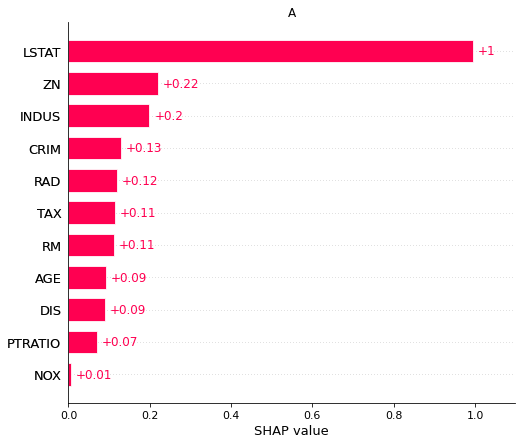

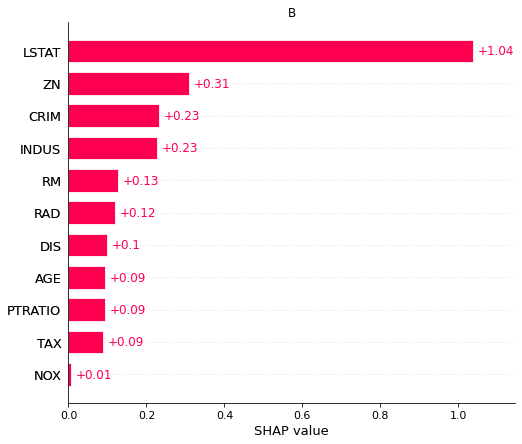

In [5]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [6]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
feature_order = feature_order[:-1]

In [7]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds, categorical_features=categorical_features)

In [8]:
feature_it = iter(feature_order)

In [9]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature(feature, classes=list(classes), alpha=0.5)

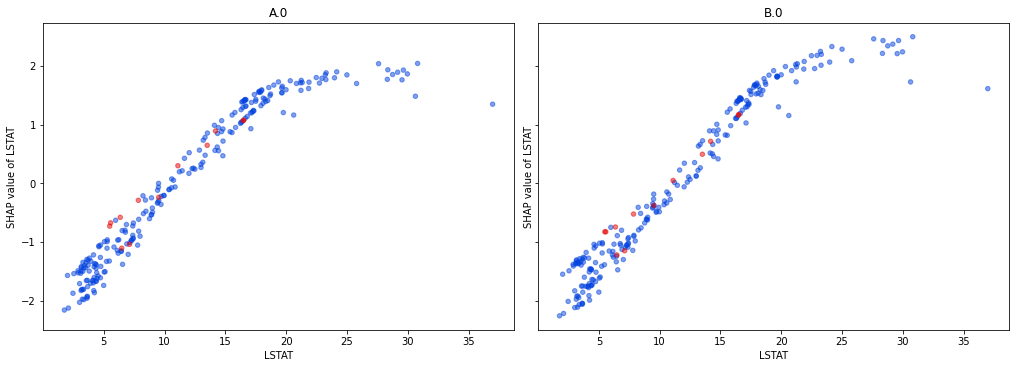

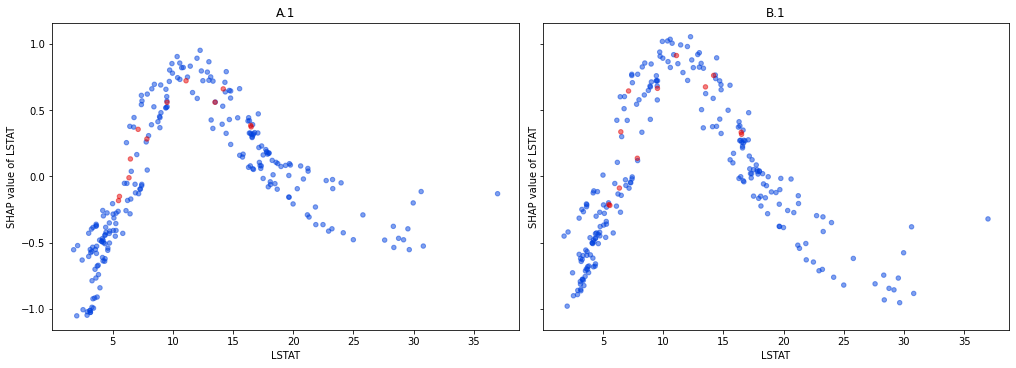

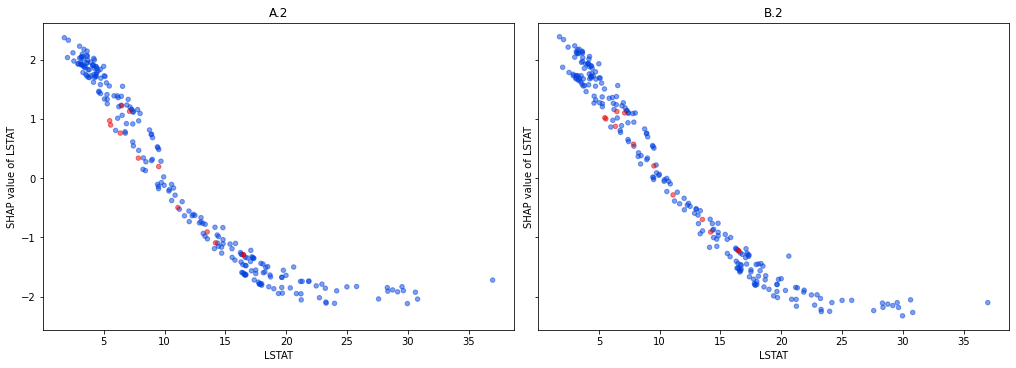

In [10]:
plot_next_feature()

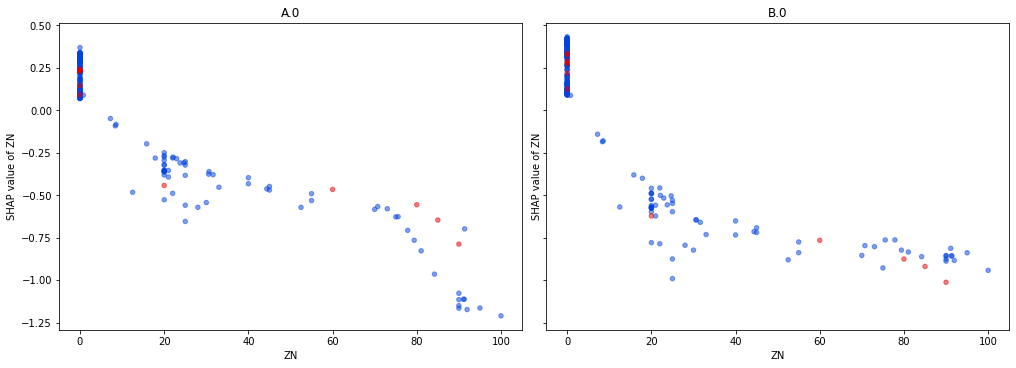

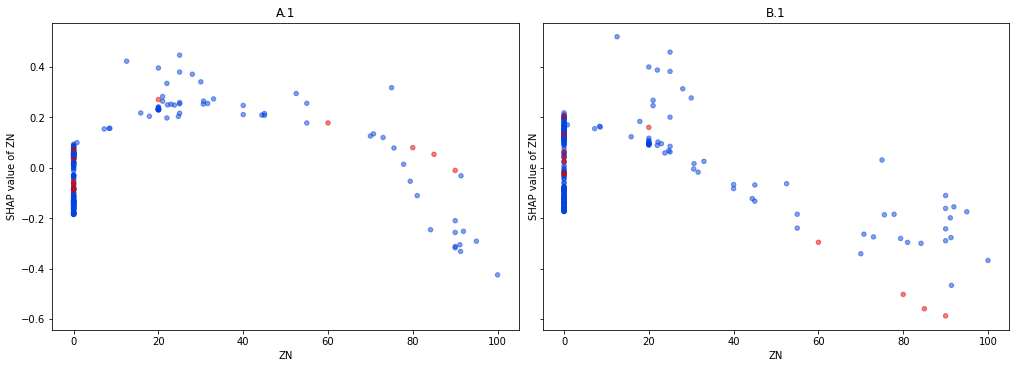

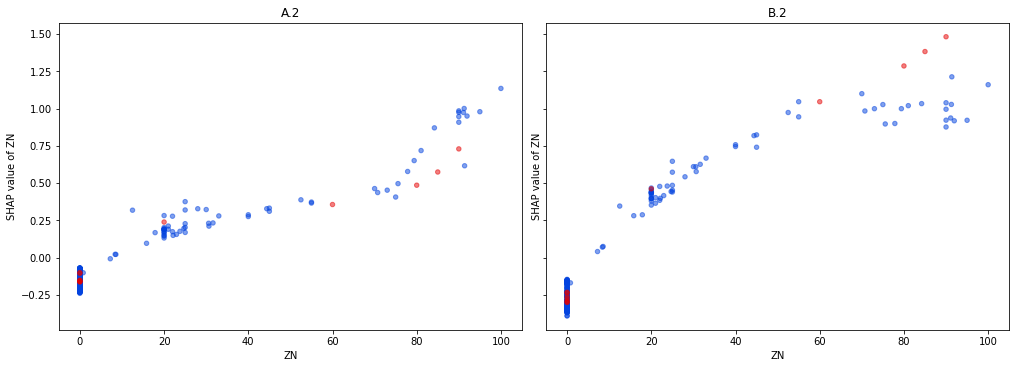

In [11]:
plot_next_feature()

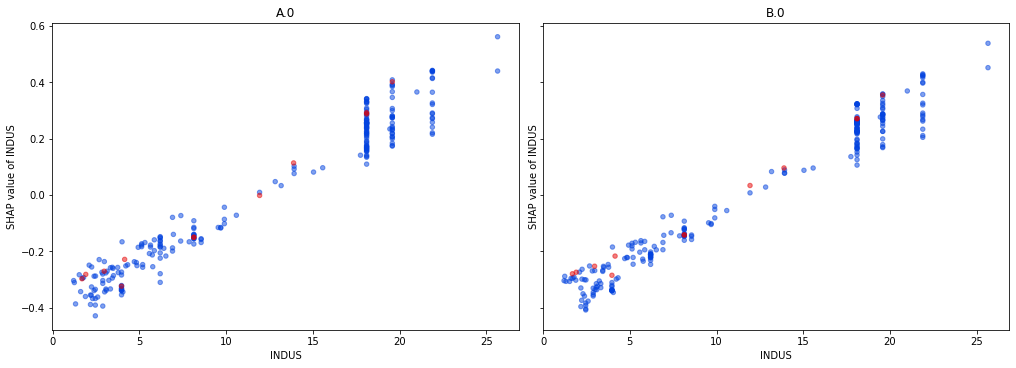

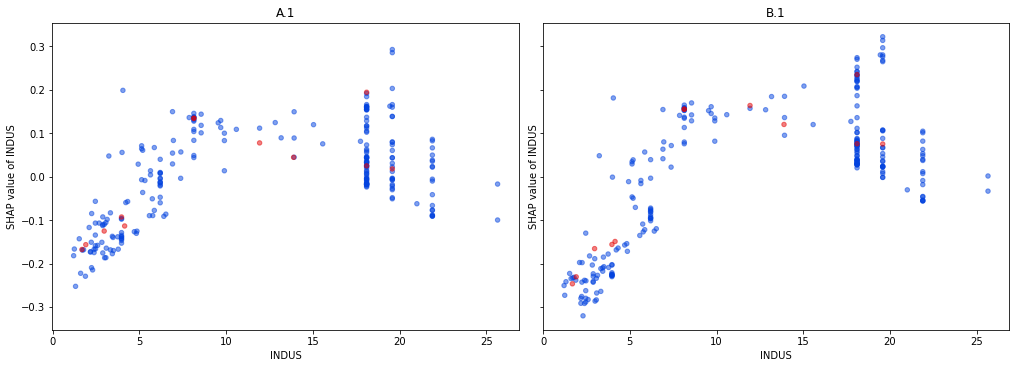

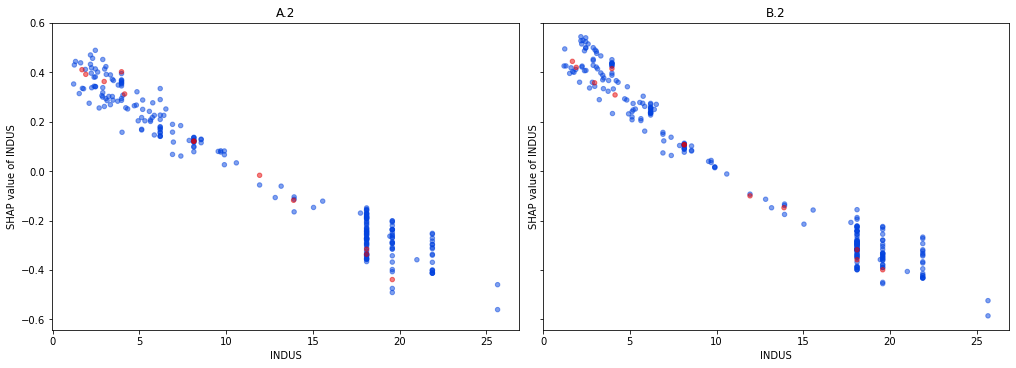

In [12]:
plot_next_feature()

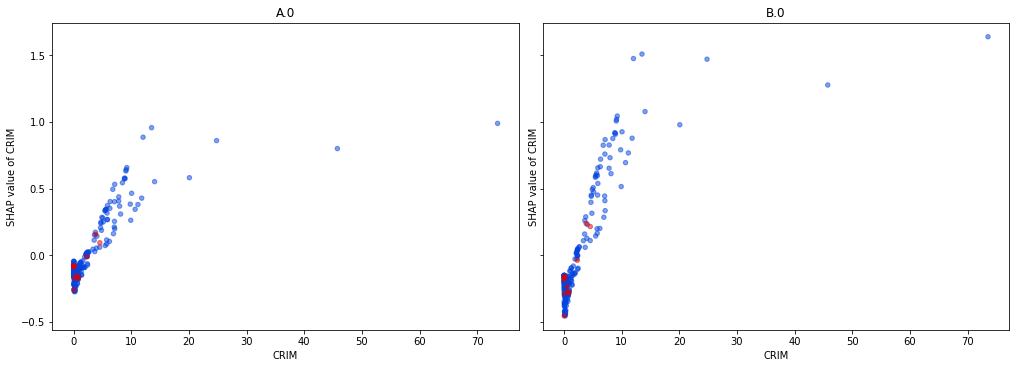

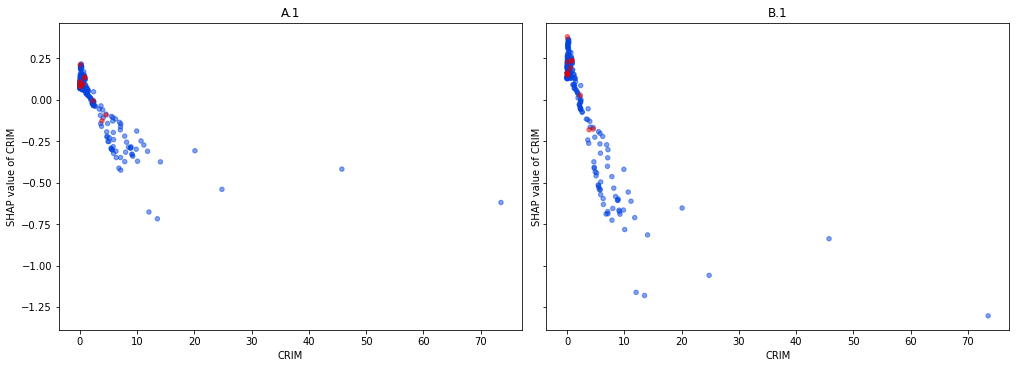

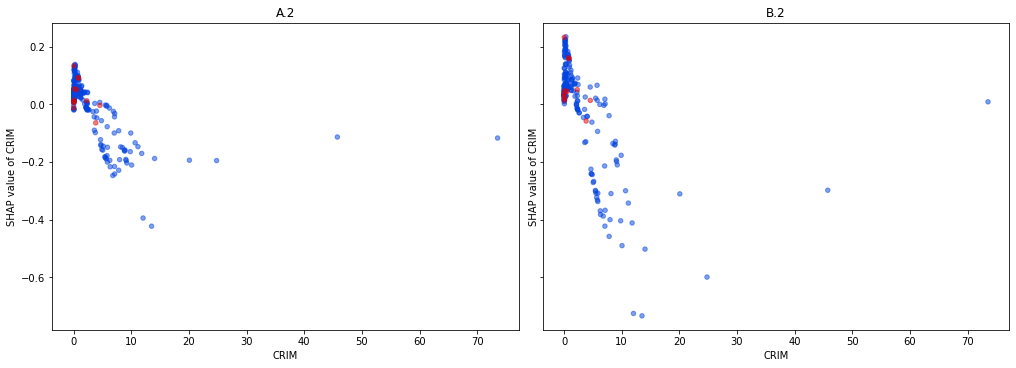

In [13]:
plot_next_feature()

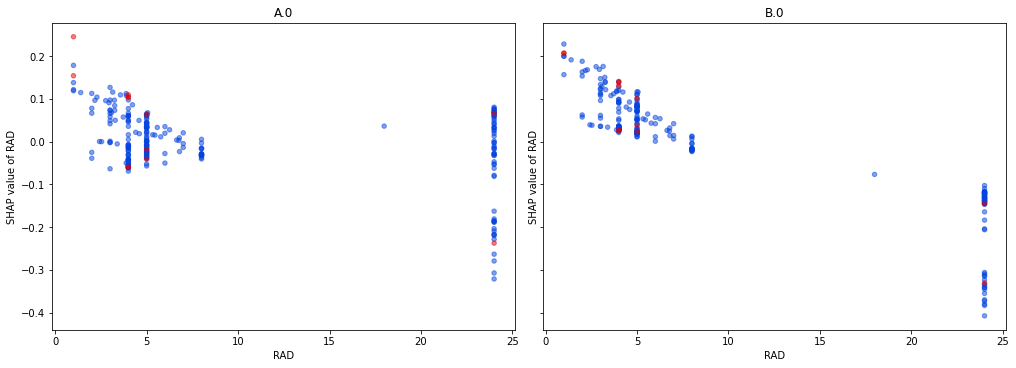

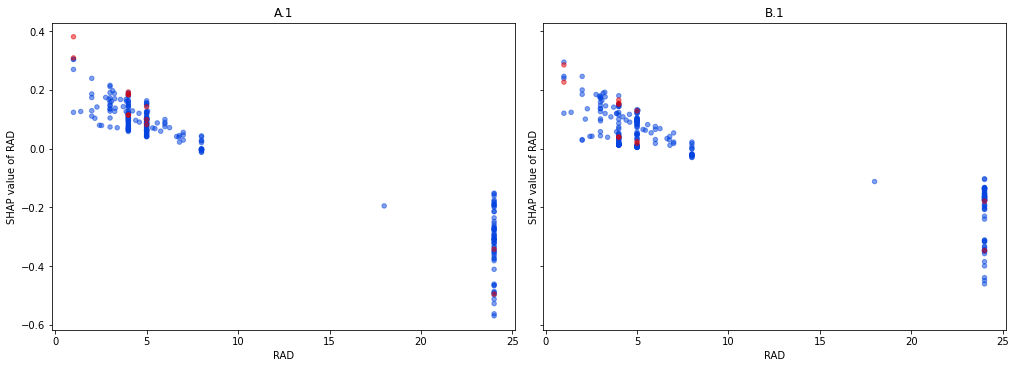

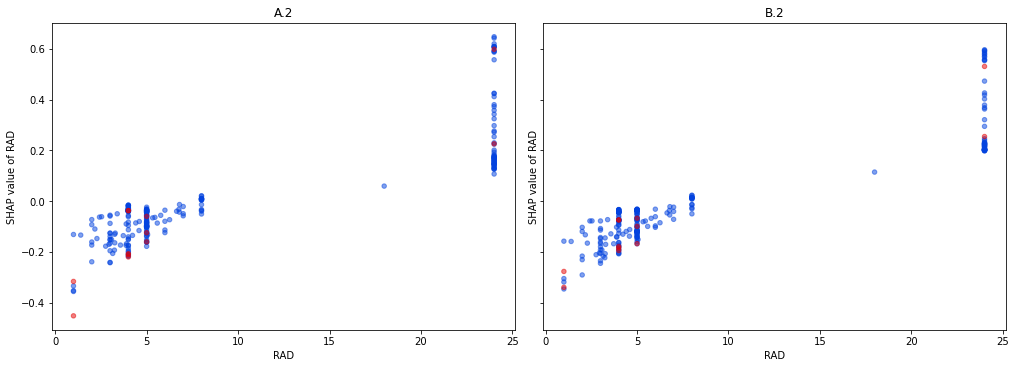

In [14]:
plot_next_feature()

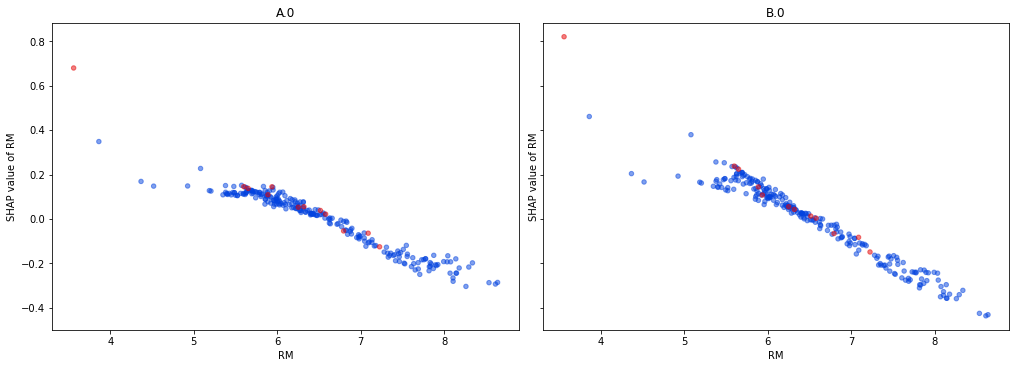

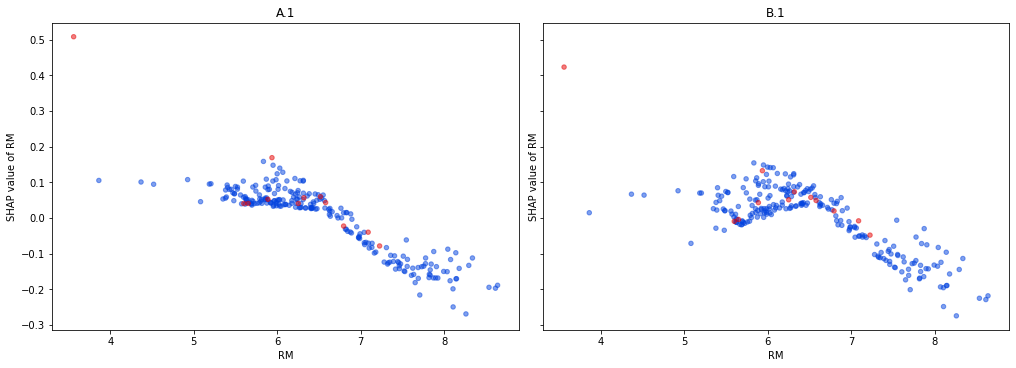

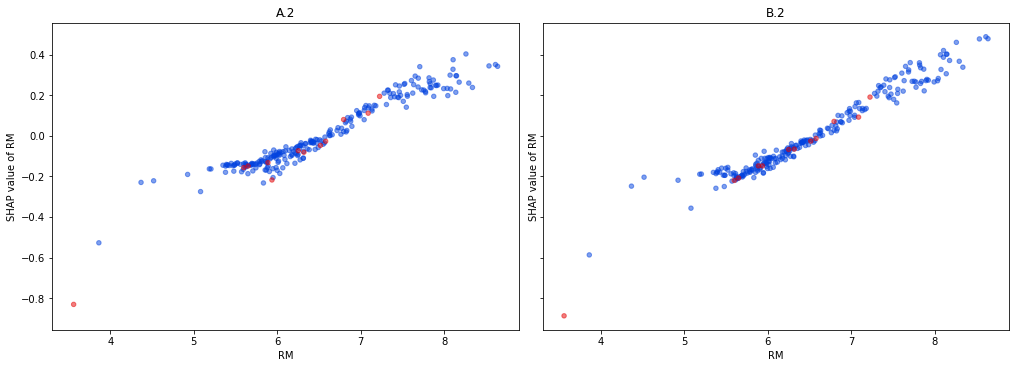

In [15]:
plot_next_feature()

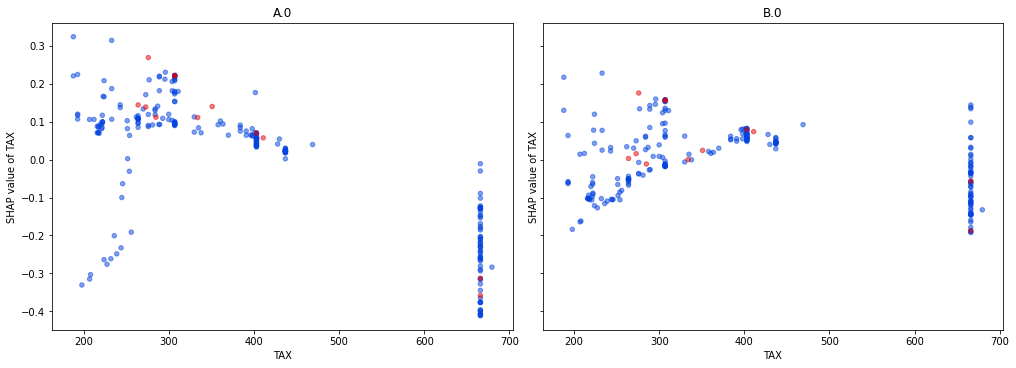

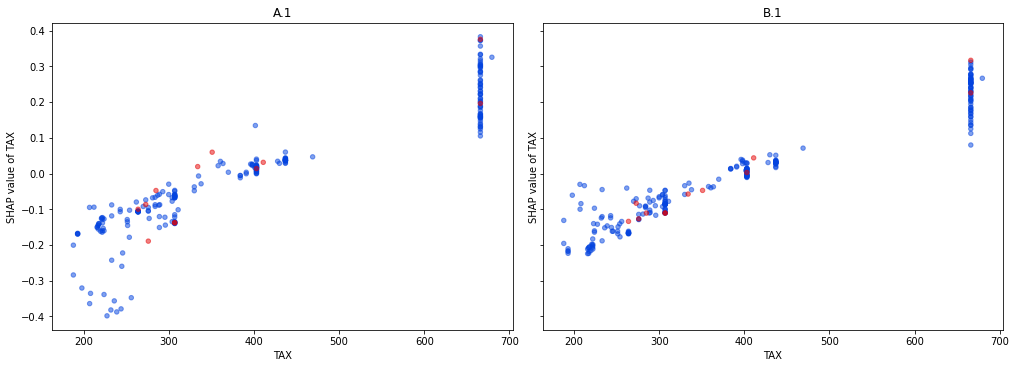

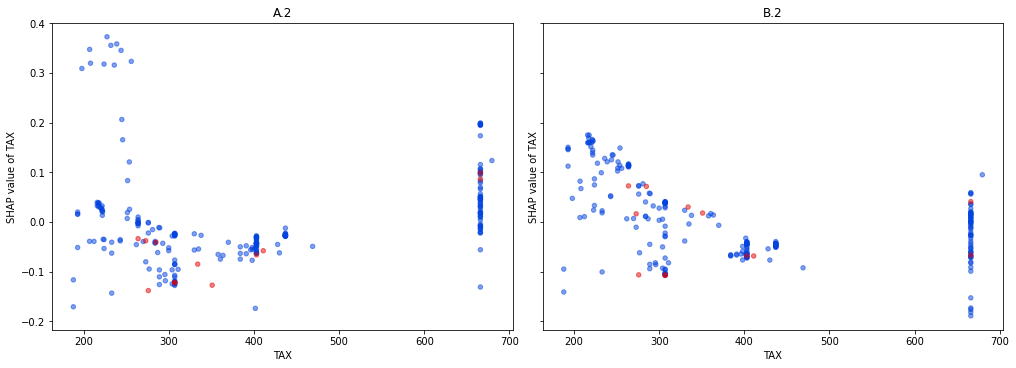

In [16]:
plot_next_feature()

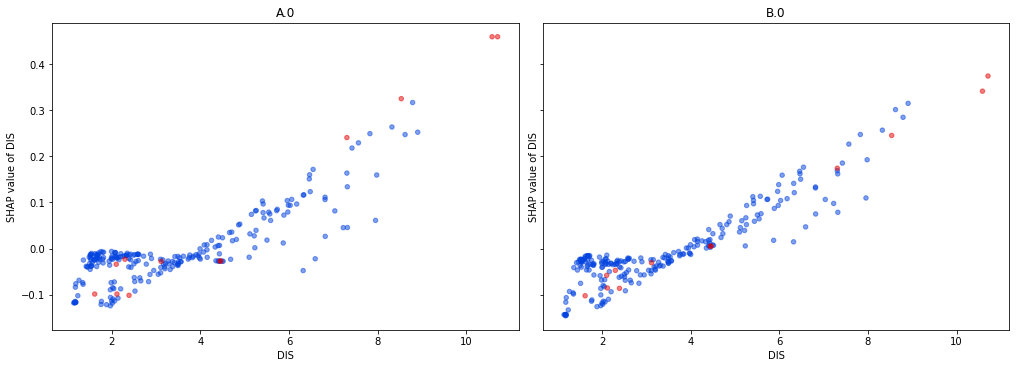

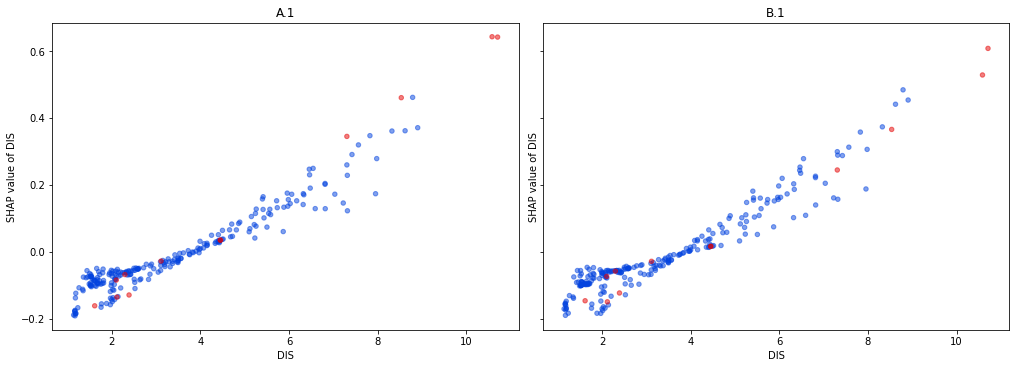

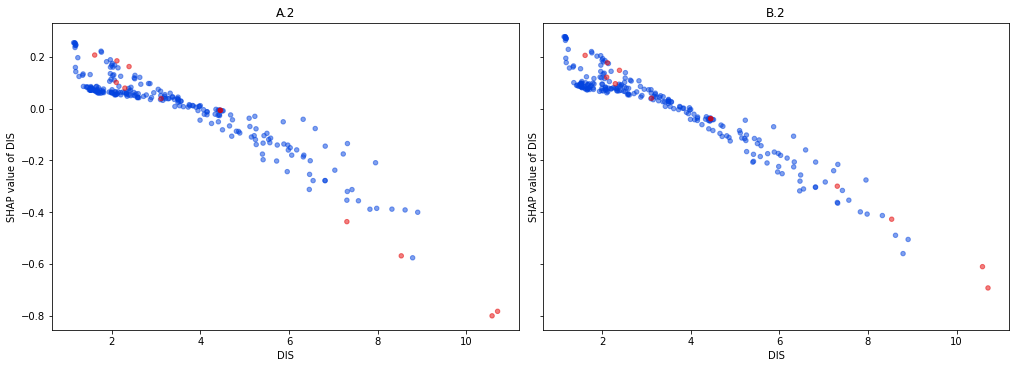

In [17]:
plot_next_feature()

The vertical spread in the dependence plots of DIS suggests that interactions are present, but more important it looks like the interactions cause different DIS effects.

The SHAP package can estimate interactions based on correlation.

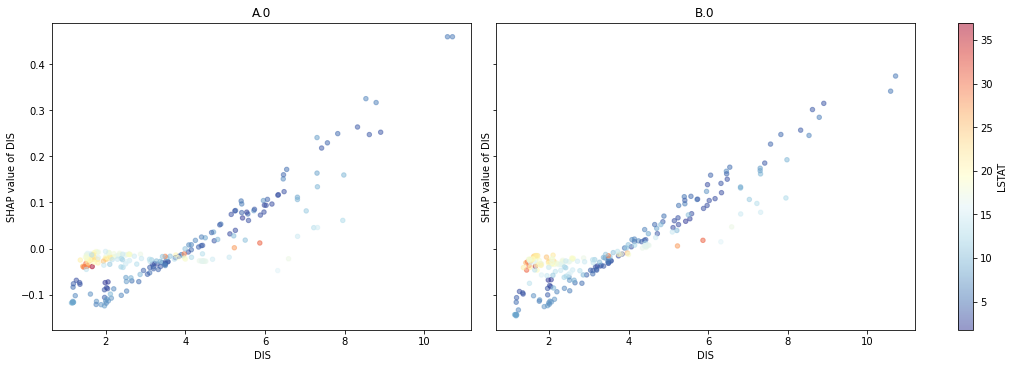

In [18]:
feature_interaction_order = estimate_feature_interaction_order(node.shap_values[:, :, 0].A, 'DIS')
node.plot_feature('DIS', classes=['A.0', 'B.0'], alpha=0.5, color=int(feature_interaction_order[0]))

The strongest interactions are with feature LSTAT, clearly instances with medium to high LSTAT values yield different effects of feature DIS than with low values.

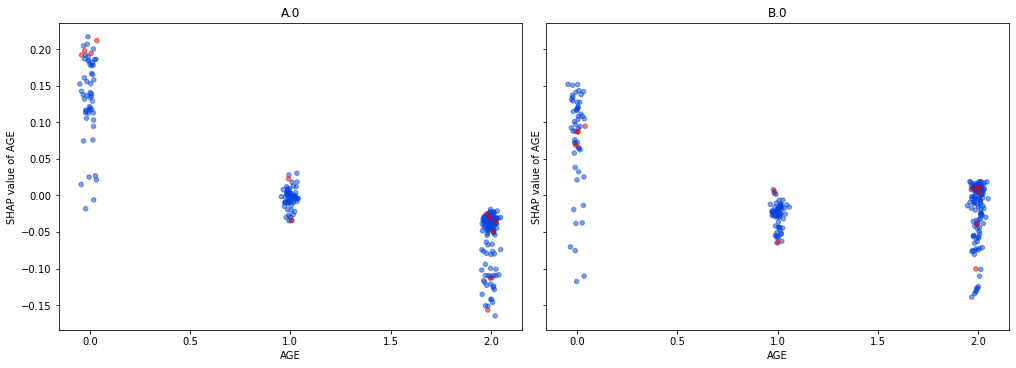

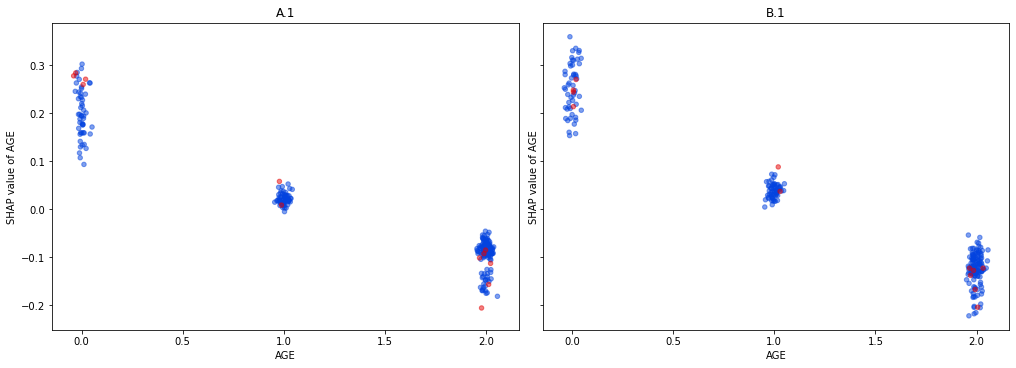

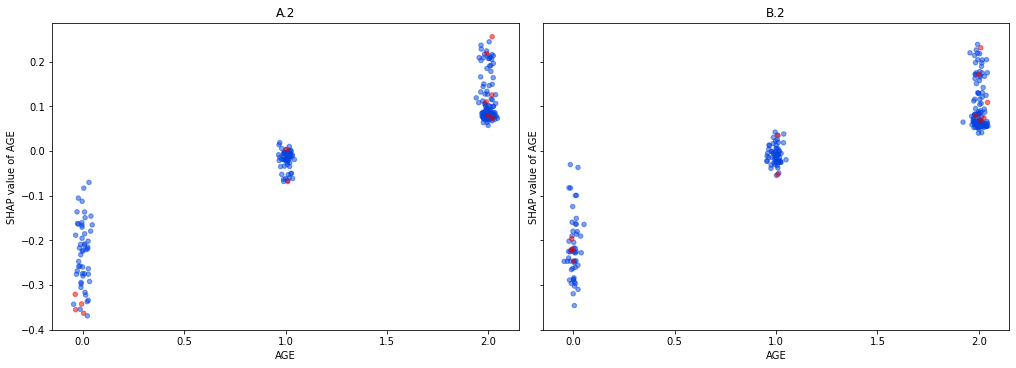

In [19]:
plot_next_feature()

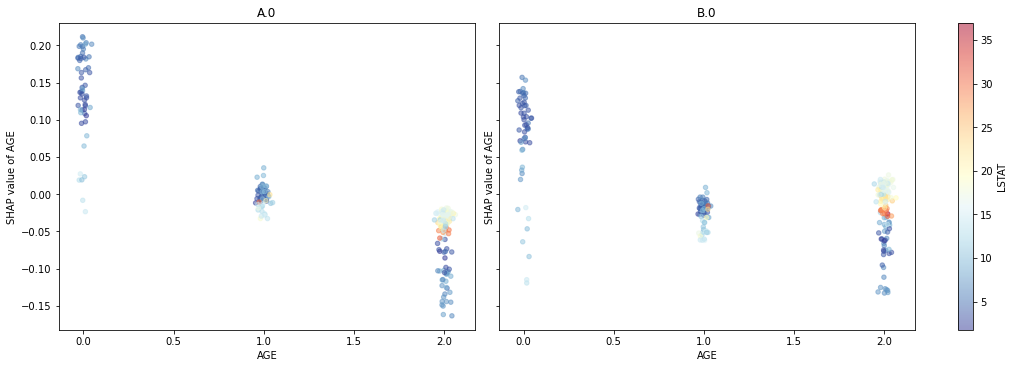

In [20]:
feature_interaction_order = estimate_feature_interaction_order(node.shap_values[:, :, 0].B, 'AGE')
node.plot_feature('AGE', classes=['A.0', 'B.0'], alpha=0.5, color=int(feature_interaction_order[0]))

For AGE too, LSTAT mainly accounts for the vertical spread.

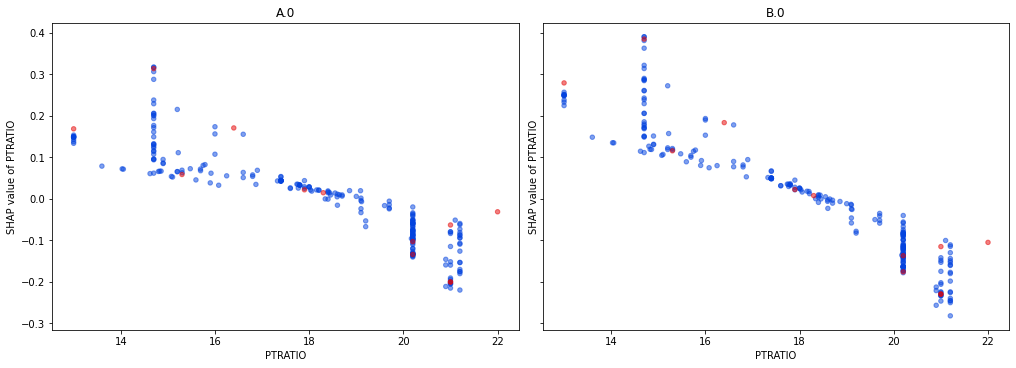

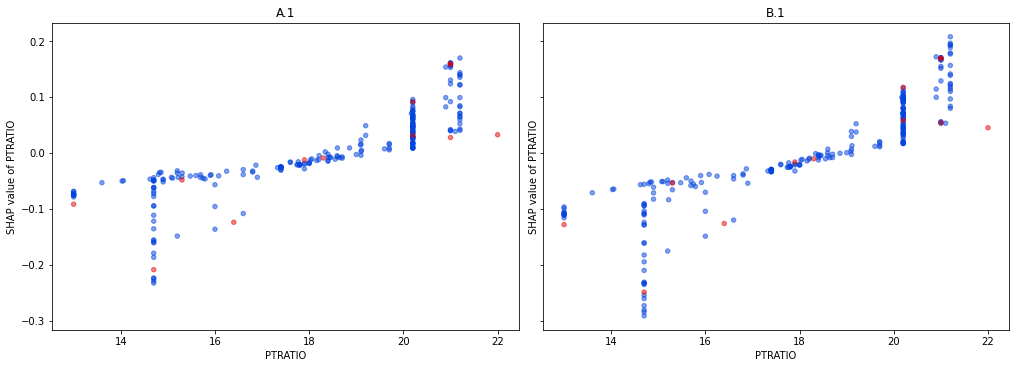

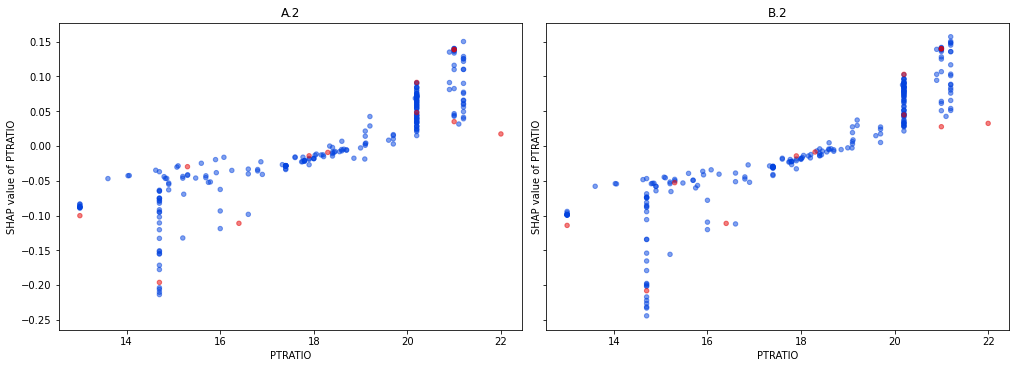

In [21]:
plot_next_feature()

# Difference Classifier SHAP Explanations

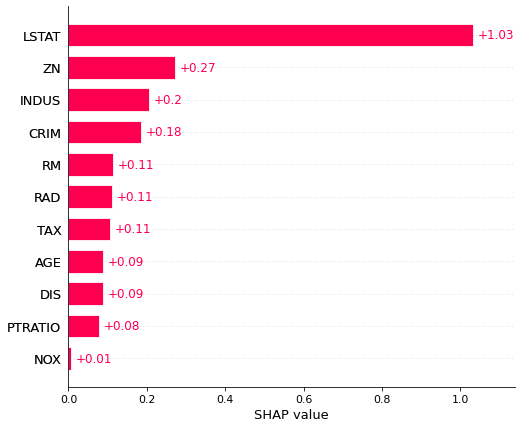

In [22]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [23]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

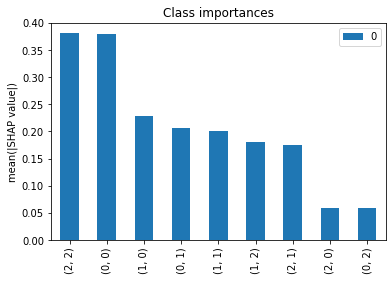

In [24]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [25]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [26]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node LLR

In [27]:
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 57.64514718994521)

In [28]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    86
 (1, 1)    24
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 19.08809905913838)

In [30]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    24
 (0, 0)     8
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 8.210760330655818)

In [32]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    16
 (0, 0)     8
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 7.750876998979743)

In [33]:
node.get_left().class_counts

(1, 1)    10
(0, 0)     6
(1, 0)     2
(0, 1)     1
dtype: int64

11.1 <= LSTAT <= 14.19
LSTAT <= 10.48 --> {'(1, 1)': 3}
LSTAT >= 14.9 --> {'(0, 0)': 3}


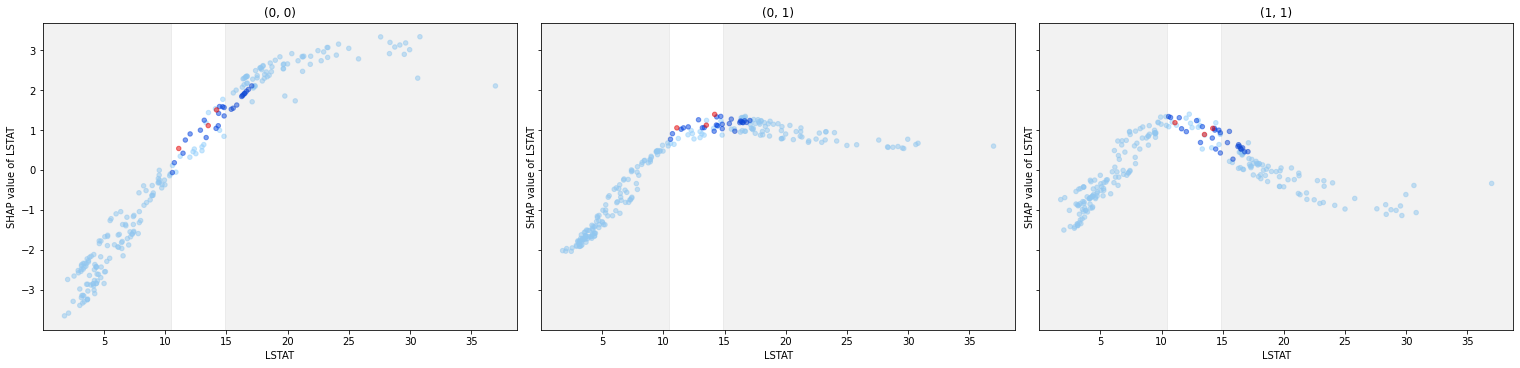

13.89 <= INDUS <= 19.58
INDUS <= 12.37 --> {'(1, 1)': 3}
INDUS >= 22.11 --> {'(0, 0)': 3}


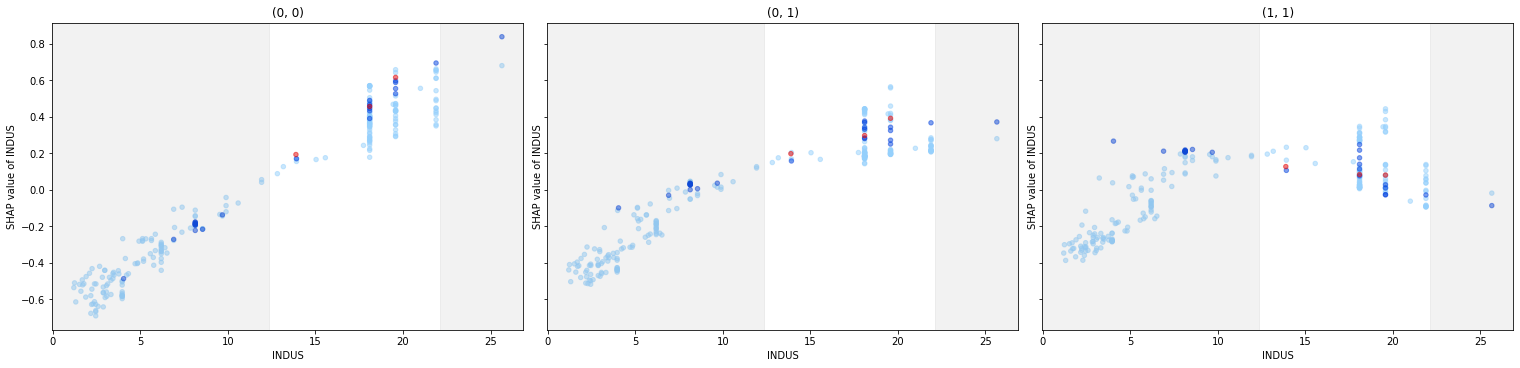

ZN <= 0.0
ZN >= 2.0 --> {'(1, 1)': 3}


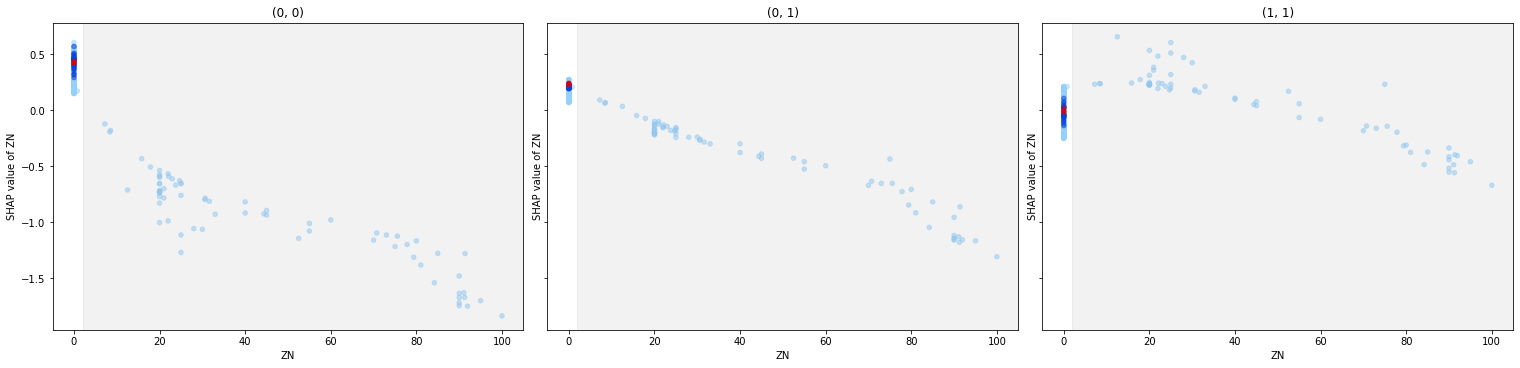

0.0456 <= CRIM <= 3.83684
CRIM >= 5.0 --> {'(0, 0)': 3}


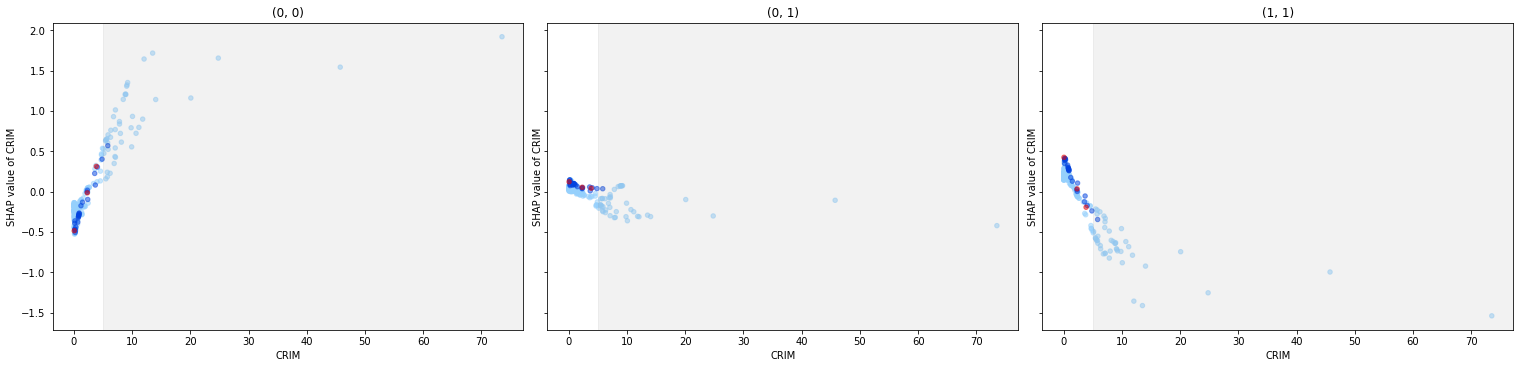

14.7 <= PTRATIO <= 20.2
PTRATIO <= 13.36 --> {'(0, 0)': 3}
PTRATIO >= 20.74 --> {'(1, 1)': 3}


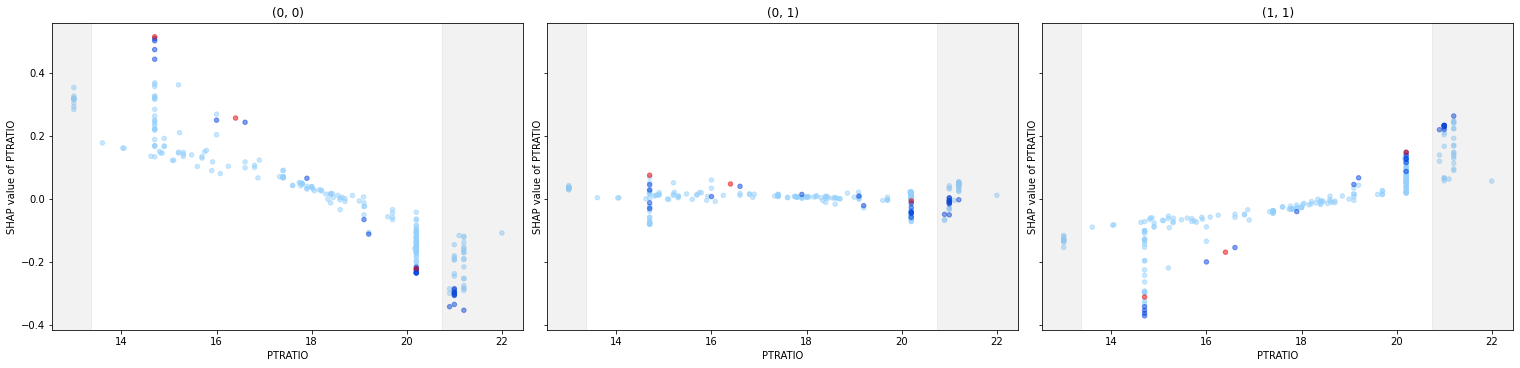

5.888 <= RM <= 6.319
RM <= 4.81 --> {'(0, 0)': 3}
RM >= 7.34 --> {'(1, 1)': 3}


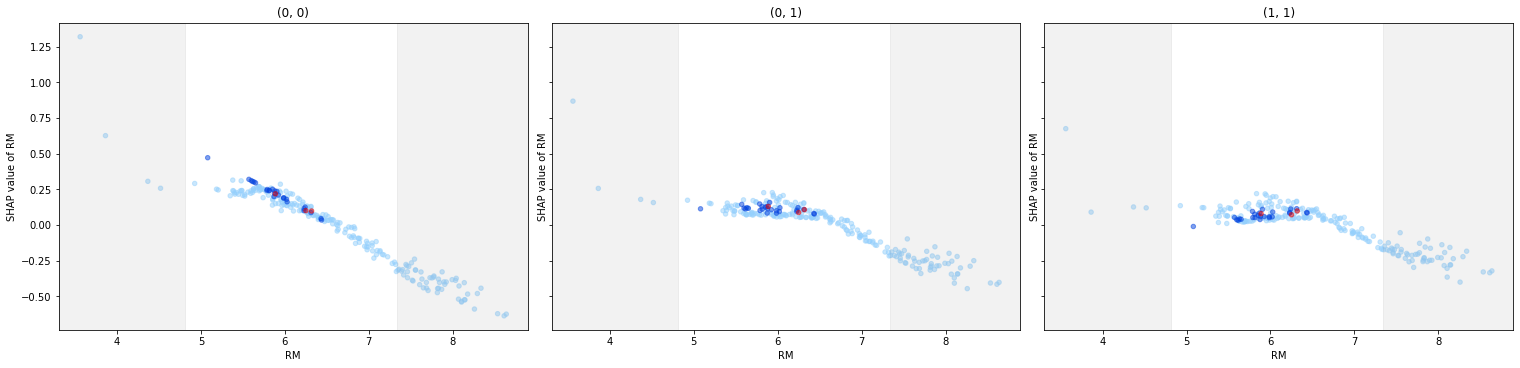

1.0 <= AGE
AGE <= 0.0 --> {'(1, 1)': 3}


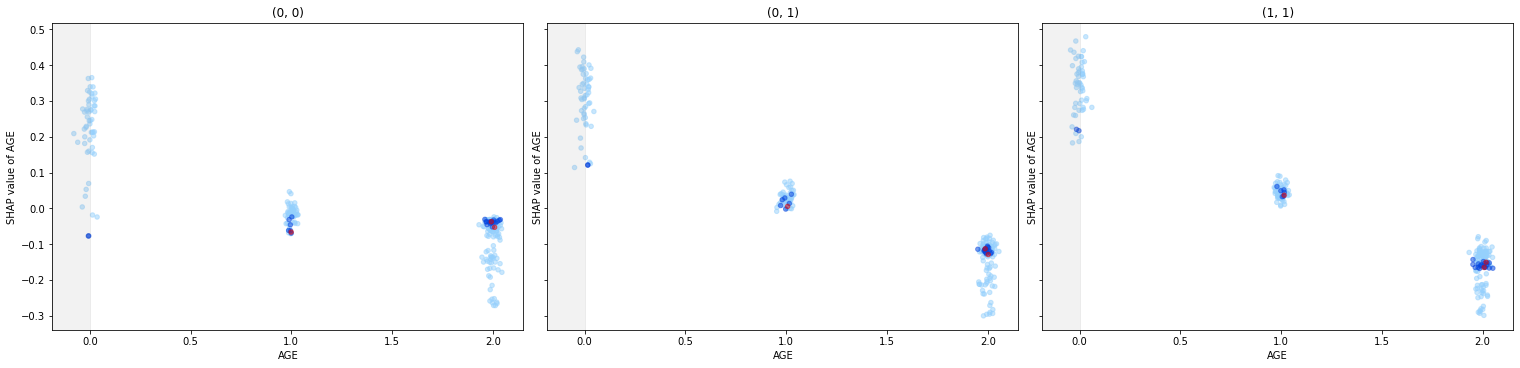

2.1 <= DIS <= 3.1121
DIS >= 6.6 --> {'(1, 1)': 3}


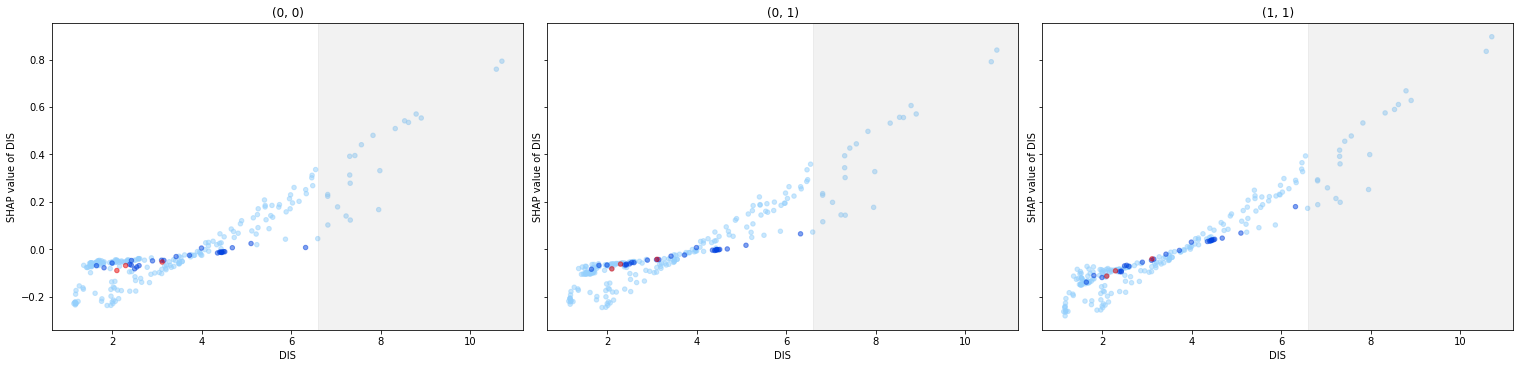

In [34]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

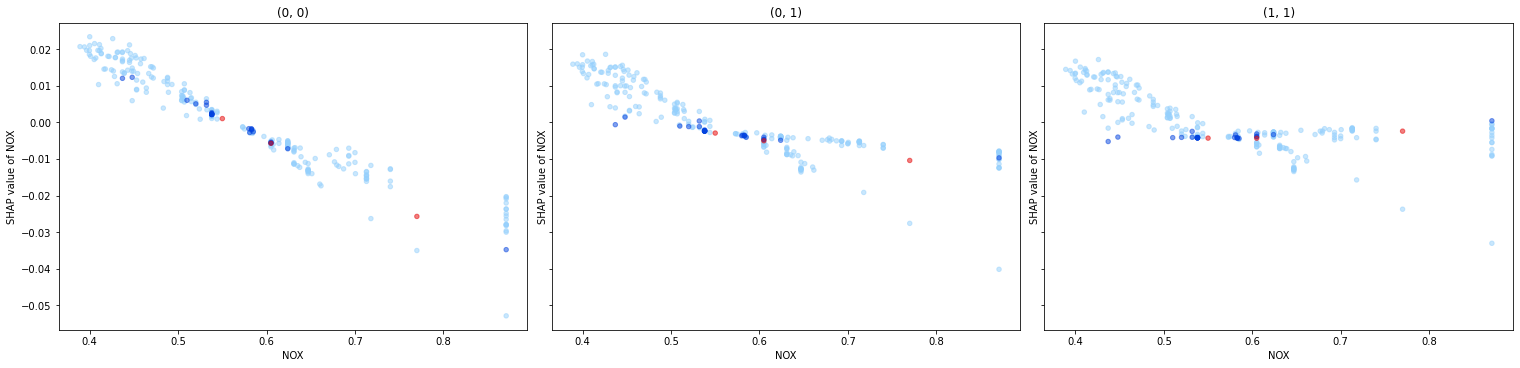

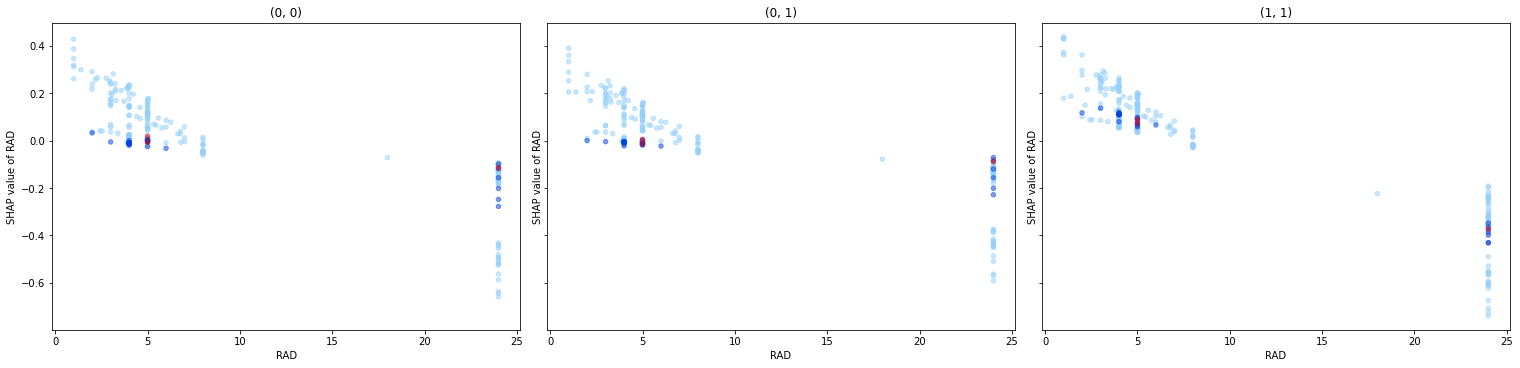

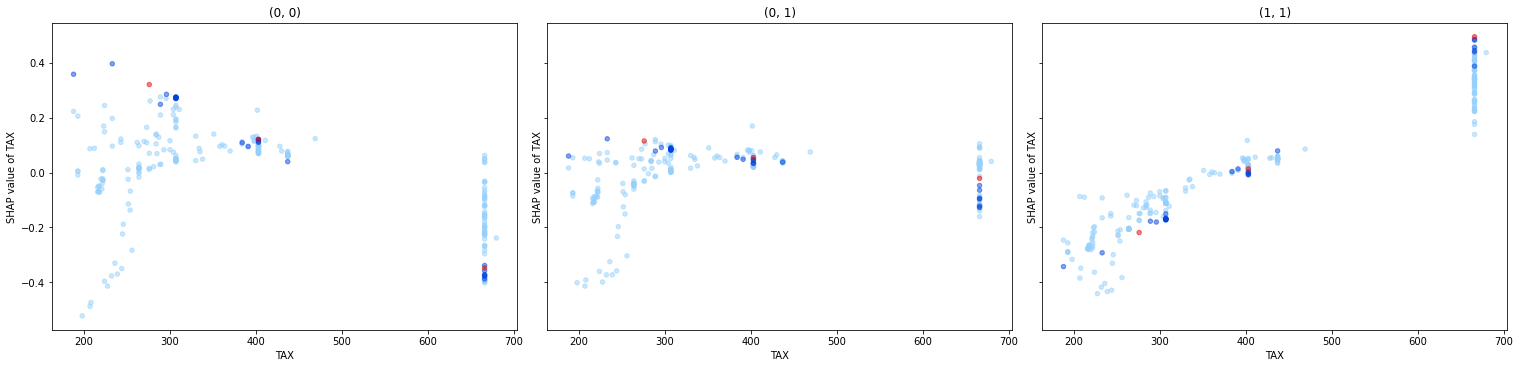

In [35]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

In the plot of feature DIS we can see, that the vertical spread of SHAP values for specific feature values is not present in the local cluster.

11.1 <= LSTAT <= 14.19
LSTAT <= 10.48 --> {'(1, 1)': 3}
LSTAT >= 14.9 --> {'(0, 0)': 3}


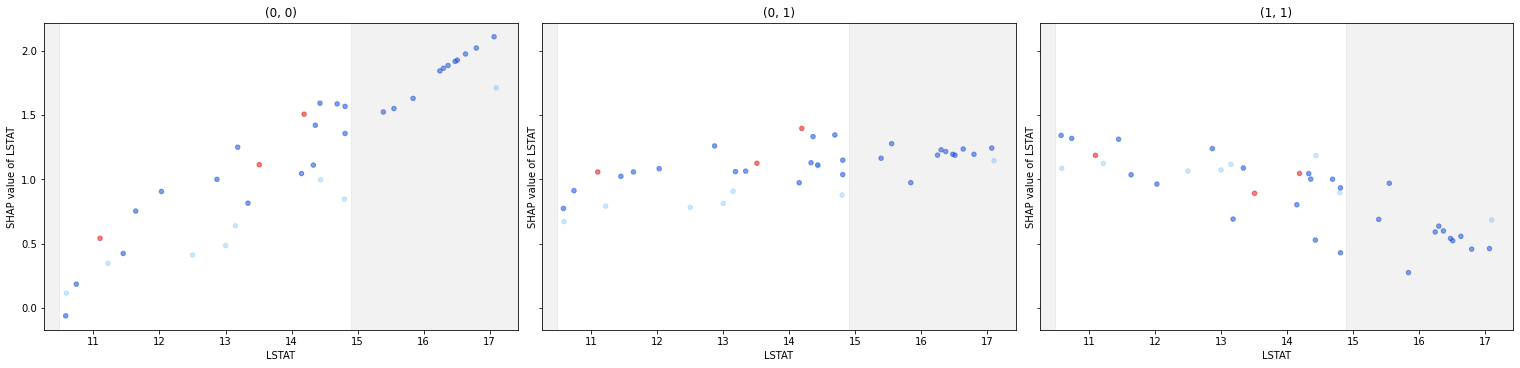

13.89 <= INDUS <= 19.58
INDUS <= 12.37 --> {'(1, 1)': 3}
INDUS >= 22.11 --> {'(0, 0)': 3}


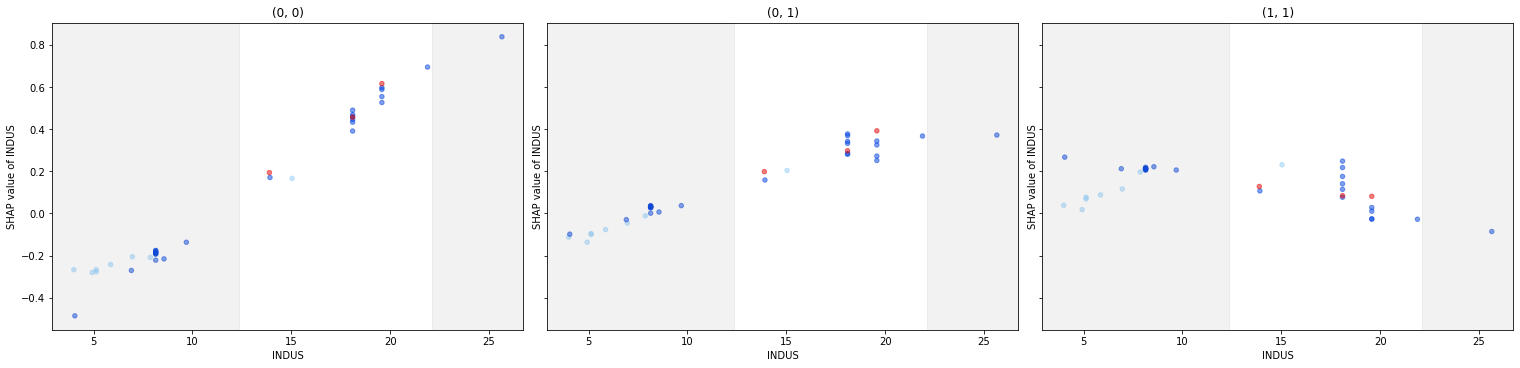

In [36]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

## Clustering of Class $(1,0)$ SHAP Values

In [37]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node LLRR

In [38]:
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 61.84152968618271)

In [39]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    86
 (1, 1)    17
 (0, 1)     3
 (1, 0)     2
 dtype: int64,
 19.70825241789352)

In [41]:
node = node.get_left()
node.class_counts, node.distance

((0, 0)    72
 (1, 1)     4
 (1, 0)     2
 dtype: int64,
 6.167000357565621)

In [46]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    43
 (1, 1)     4
 (1, 0)     2
 dtype: int64,
 5.590202124260822)

In [48]:
node = node.get_right()
node.class_counts, node.distance

((0, 0)    24
 (1, 1)     4
 (1, 0)     2
 dtype: int64,
 2.903174490984177)

In [52]:
node.get_right().distance

2.0995210268427913

The distance is not decreased much to the next lower child cluster

16.476581495471024 <= LSTAT <= 16.51
LSTAT <= 16.33 --> {'(1, 1)': 2}
LSTAT >= 16.72 --> {'(0, 0)': 2}


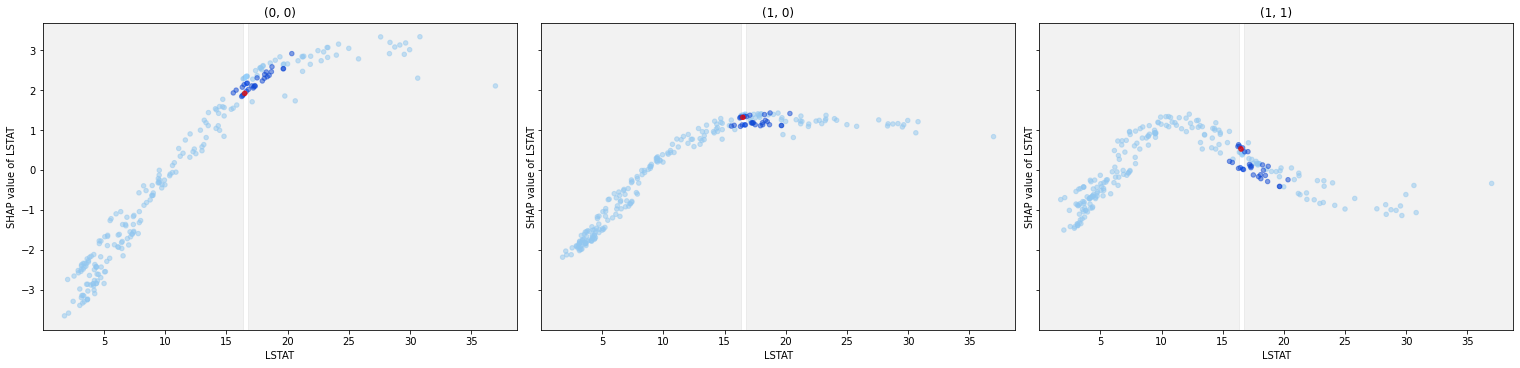

ZN <= 0.0
ZN >= 1.0 --> {'(1, 1)': 2}


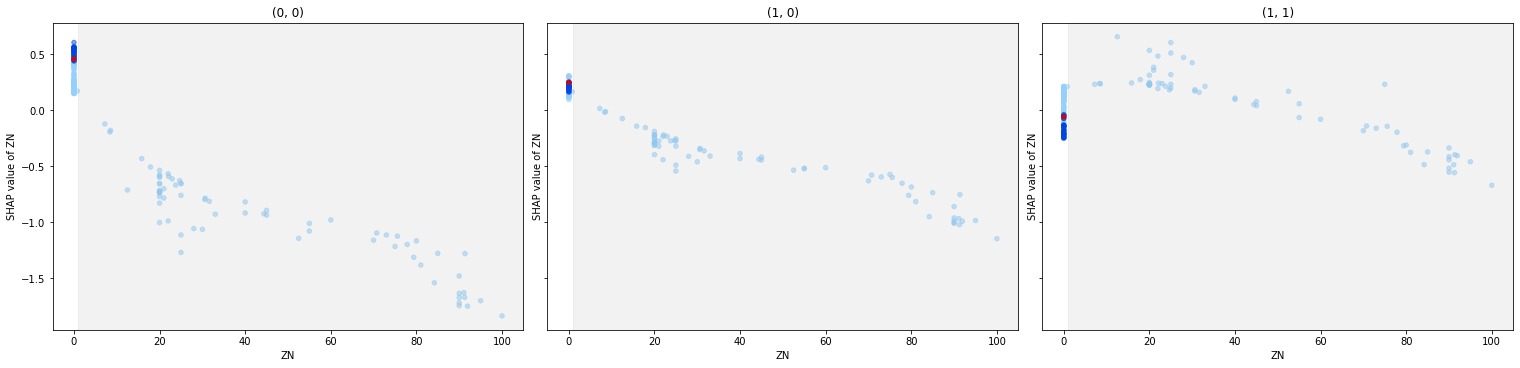

8.14 <= INDUS <= 8.14
INDUS <= 7.13 --> {'(1, 1)': 2}
INDUS >= 9.15 --> {'(0, 0)': 2}


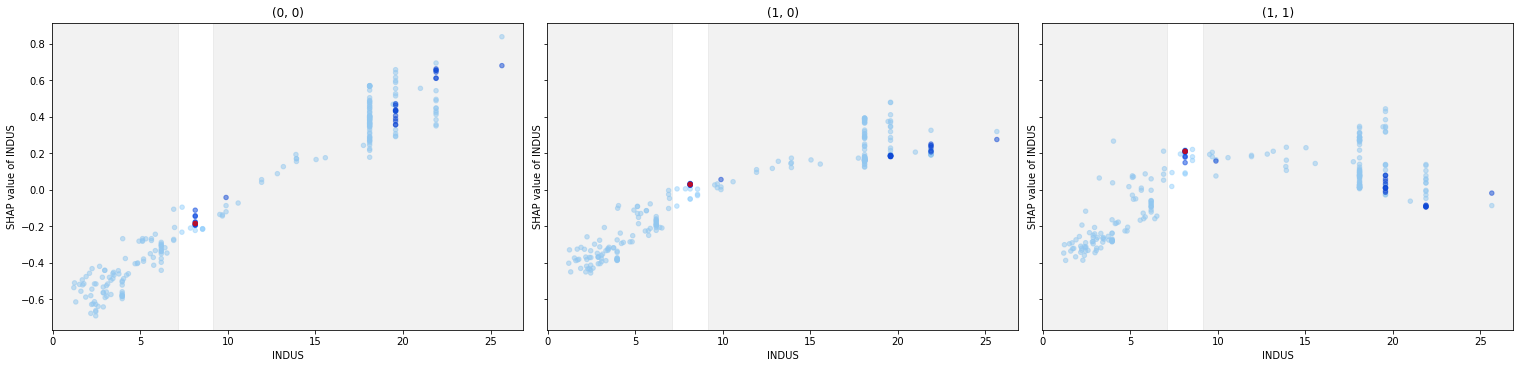

21.0 <= PTRATIO <= 21.0
PTRATIO <= 20.58 --> {'(0, 0)': 2}
PTRATIO >= 21.39 --> {'(1, 1)': 2}


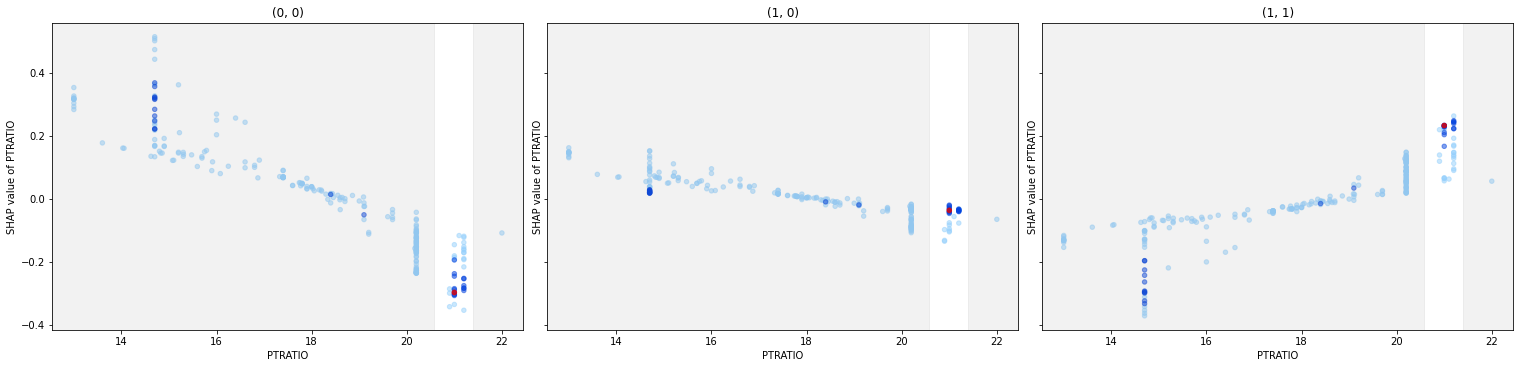

0.8261732257672565 <= CRIM <= 0.84054
CRIM <= 0.0 --> {'(1, 1)': 2}
CRIM >= 2.0 --> {'(0, 0)': 2}


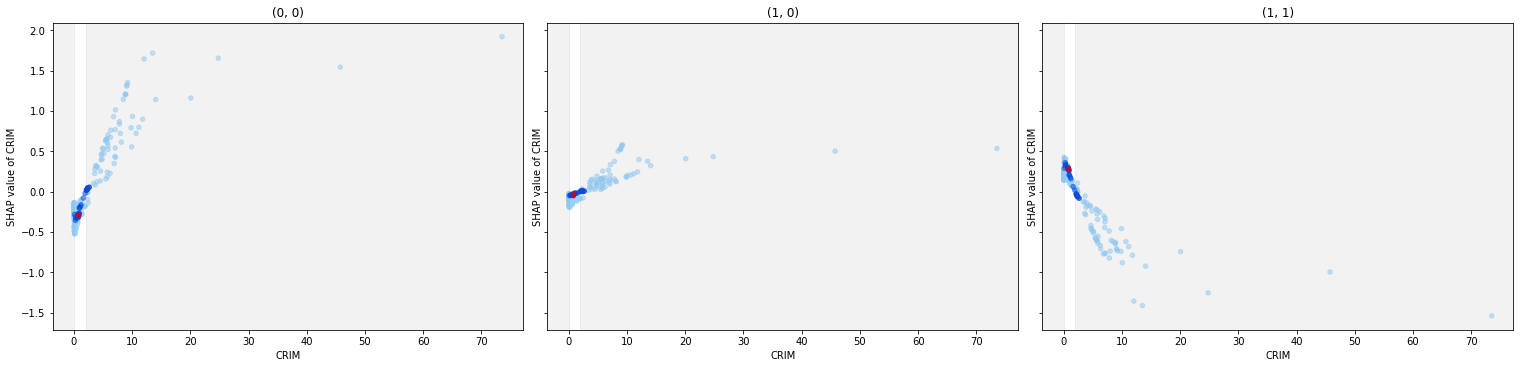

5.599 <= RM <= 5.65071911415199
RM <= 5.22 --> {'(0, 0)': 2}
RM >= 5.76 --> {'(1, 1)': 2}


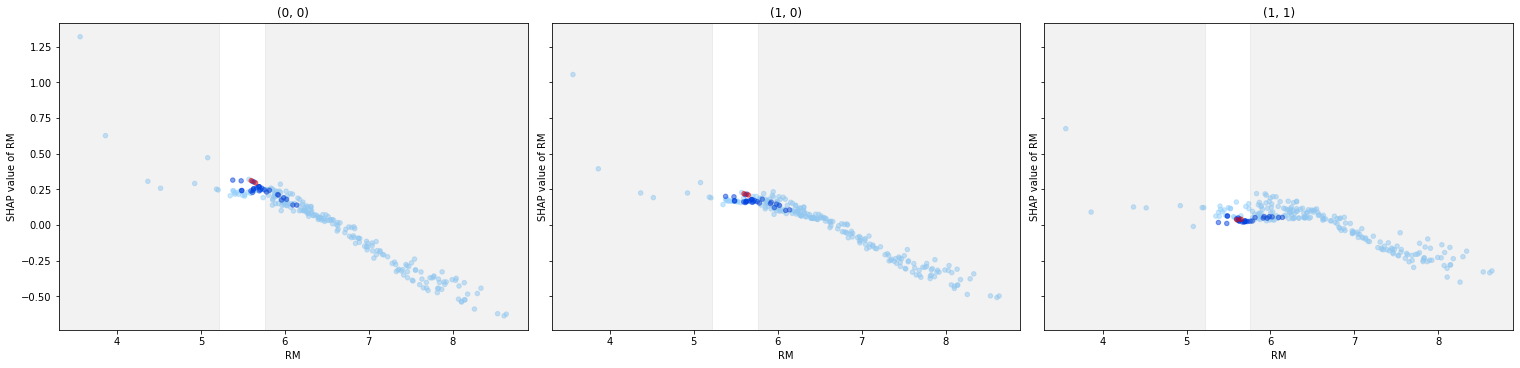

307.0 <= TAX <= 307.0
TAX <= 288.0 --> {'(0, 0)': 2}
TAX >= 327.0 --> {'(1, 1)': 2}


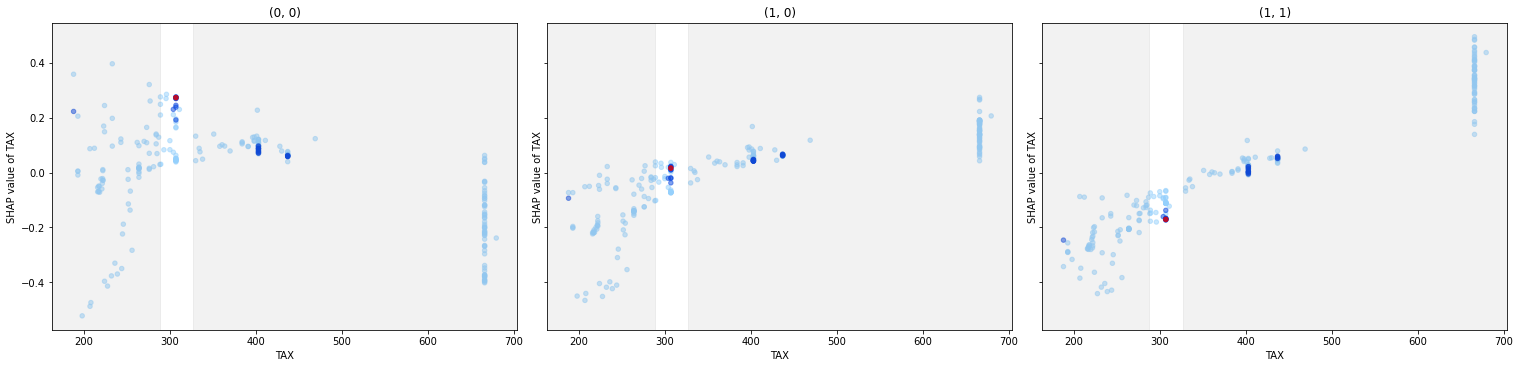

2.0 <= AGE
AGE <= 1.0 --> {'(1, 1)': 2}


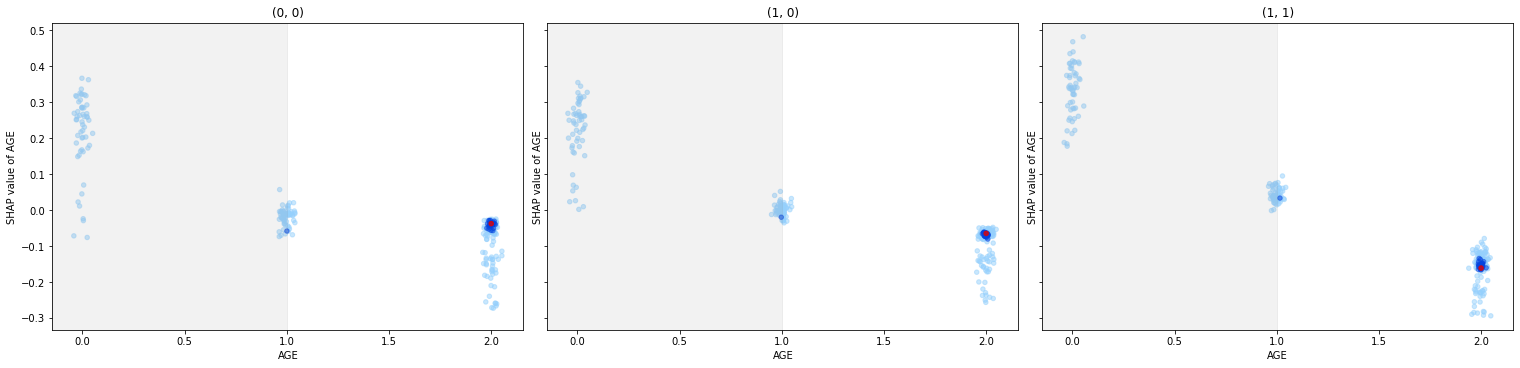

4.4458475345281245 <= DIS <= 4.4546
DIS <= 2.93 --> {'(1, 1)': 1, '(0, 0)': 1}


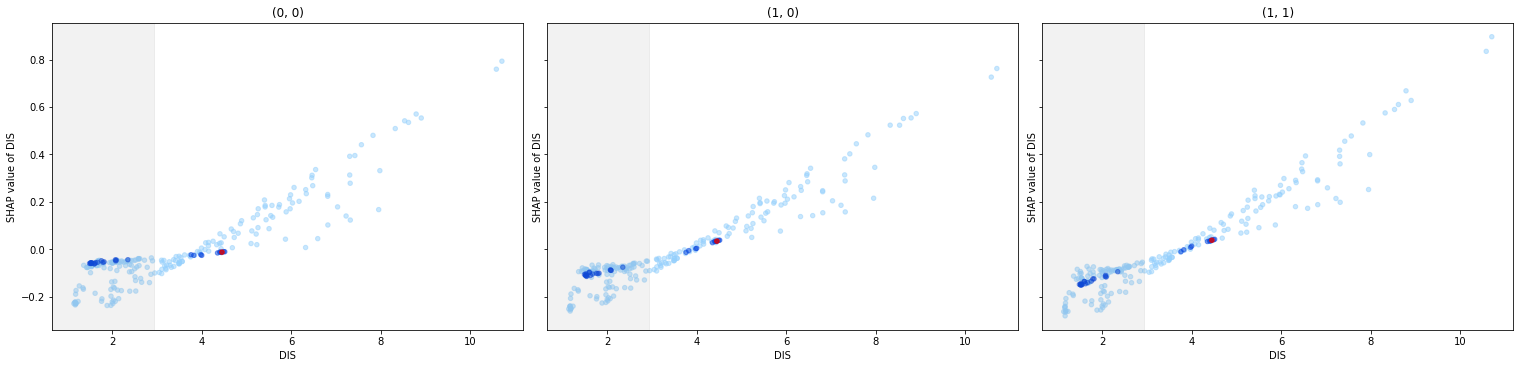

4.0 <= RAD <= 4.0
RAD >= 5.94 --> {'(0, 0)': 2}


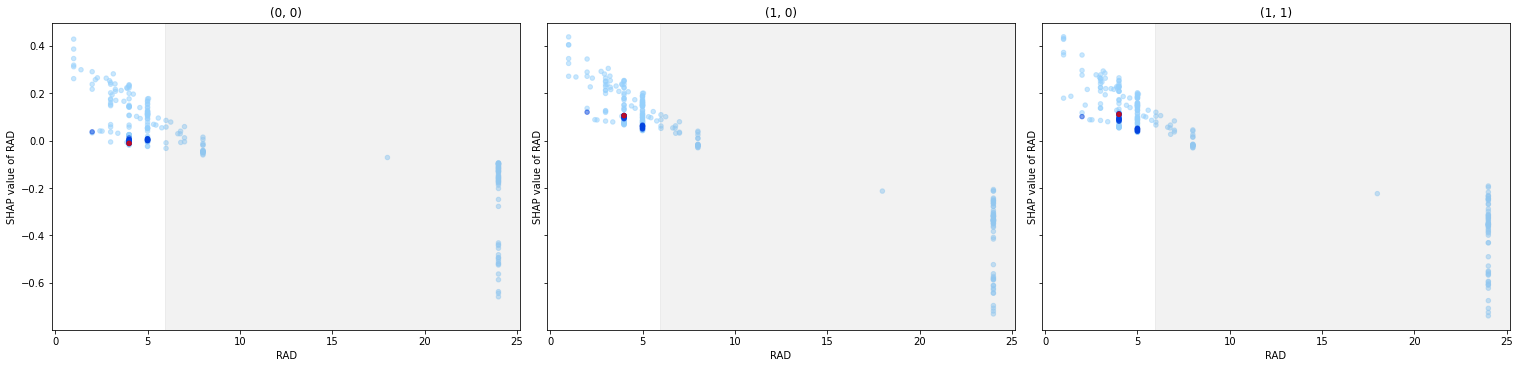

In [53]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

For DIS, the local partial dependence is nearly linear and further makes up the less extreme part of the global explanation, showing different degrees of linear relations.

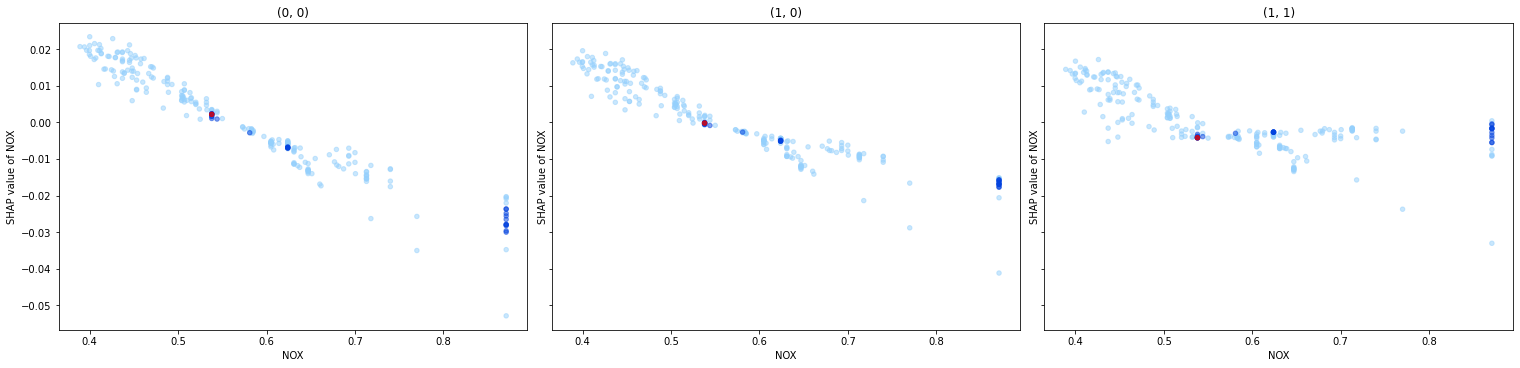

In [54]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

16.476581495471024 <= LSTAT <= 16.51
LSTAT <= 16.33 --> {'(1, 1)': 2}
LSTAT >= 16.72 --> {'(0, 0)': 2}


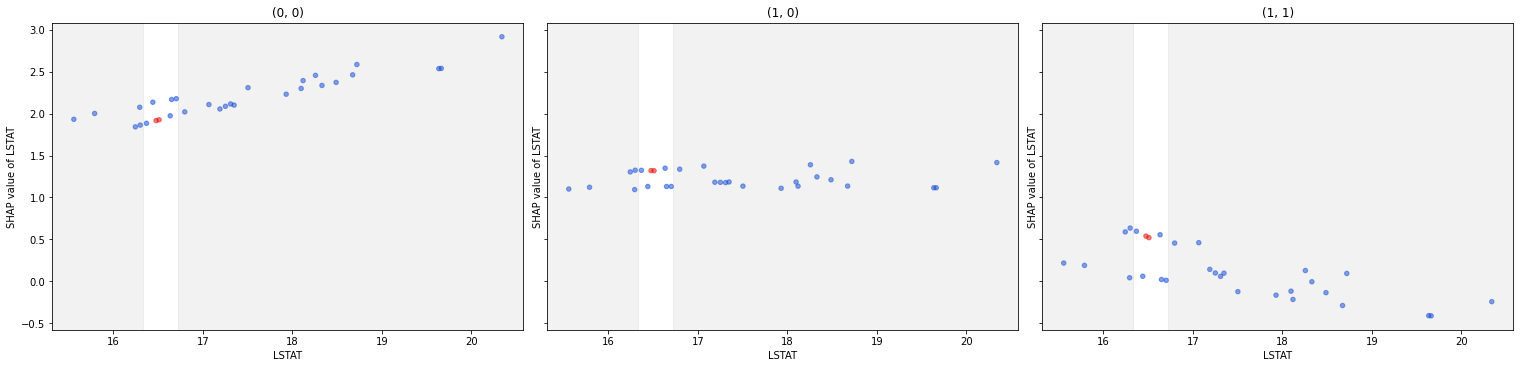

ZN <= 0.0
ZN >= 1.0 --> {'(1, 1)': 2}


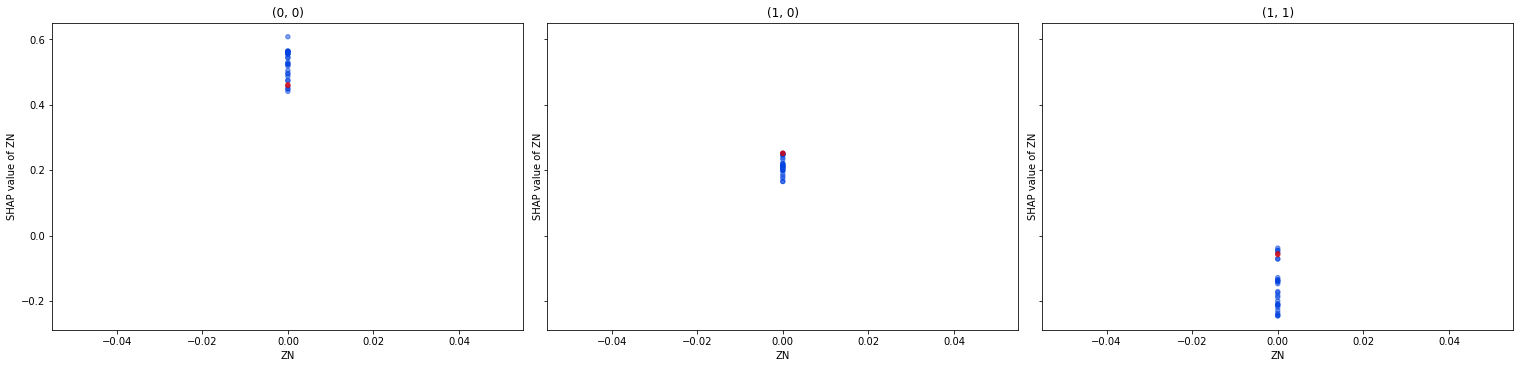

In [55]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, focus=node, alpha=0.5)

## Clustering of Class $(1,2)$ SHAP Values

In [56]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node RRL

In [57]:
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 66.9114656985999)

In [58]:
node = node.get_right()
node.class_counts, node.distance

((2, 2)    96
 (1, 1)    52
 (0, 0)    12
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 40.32750451580308)

In [60]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    39
 (0, 0)    12
 (1, 2)     5
 (0, 1)     3
 (1, 0)     2
 (2, 2)     1
 dtype: int64,
 28.50047904233932)

In [62]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    13
 (1, 2)     5
 (2, 2)     1
 dtype: int64,
 13.32955575358383)

In [63]:
node.get_left().class_counts

(1, 2)    4
(1, 1)    1
dtype: int64

The distance of this cluster is much higher than in the final local clusters of the previous classes. Further, the most important local cluster ZN has a quite extreme counterfactual and wide spread of feature values where this difference class is predicted.

20.0 <= ZN <= 90.0
ZN <= 16.0 --> {'(1, 1)': 5}


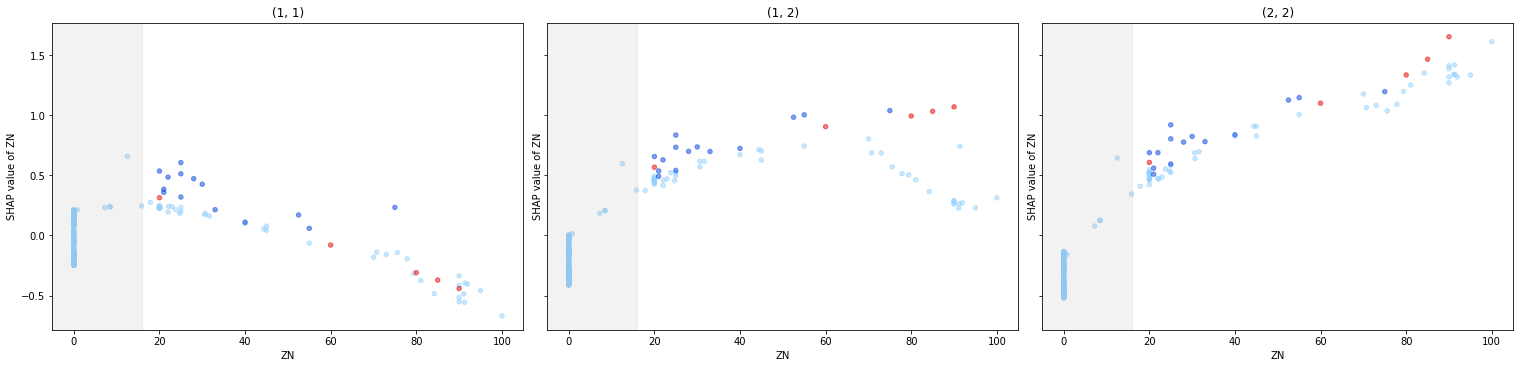

5.49 <= LSTAT <= 9.522242201272585
LSTAT <= 3.58 --> {'(2, 2)': 5}
LSTAT >= 11.59 --> {'(1, 1)': 5}


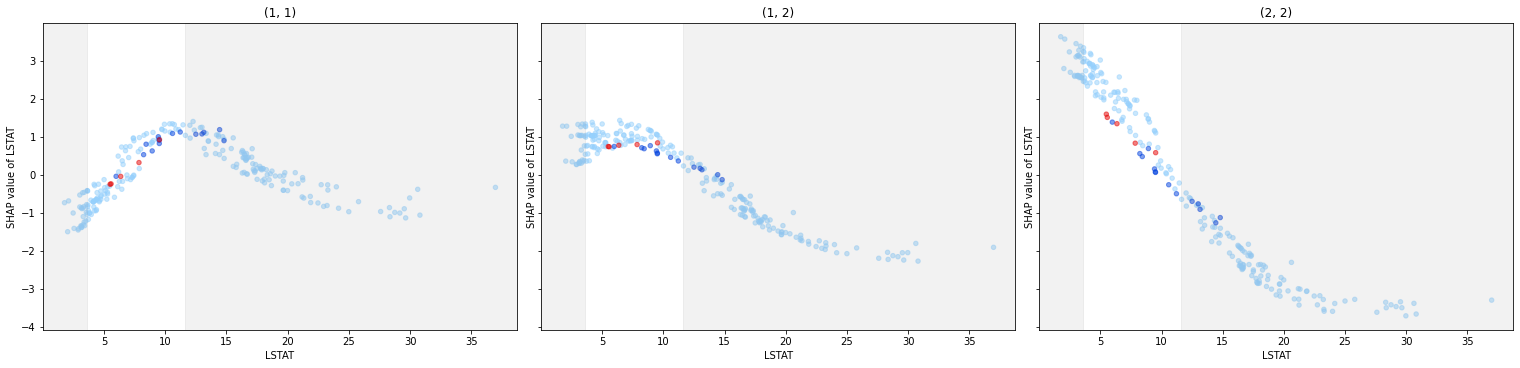

2.1153479553520422 <= DIS
DIS <= 1.94 --> {'(2, 2)': 5}


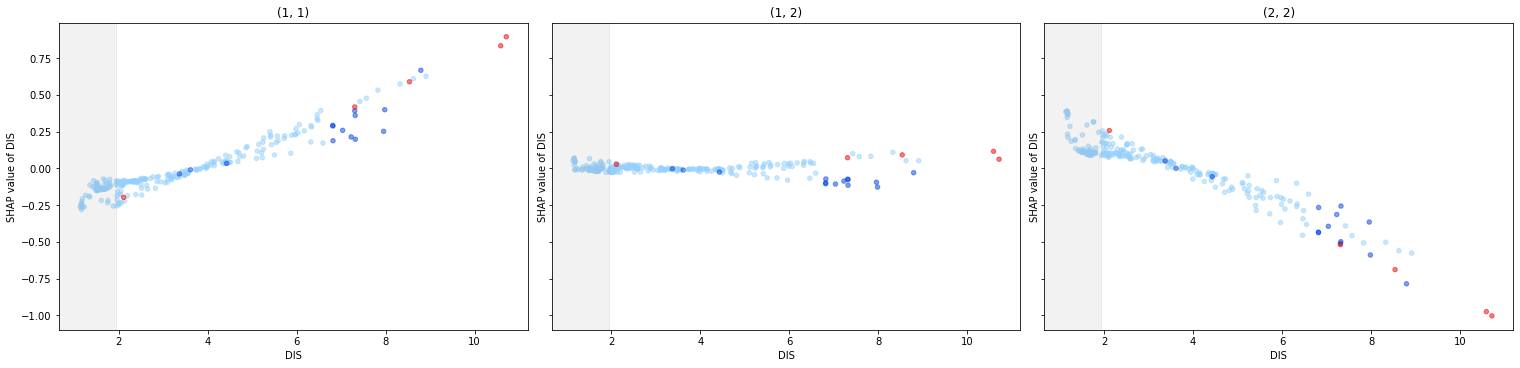

1.69 <= INDUS <= 4.15
INDUS >= 16.13 --> {'(1, 1)': 5}


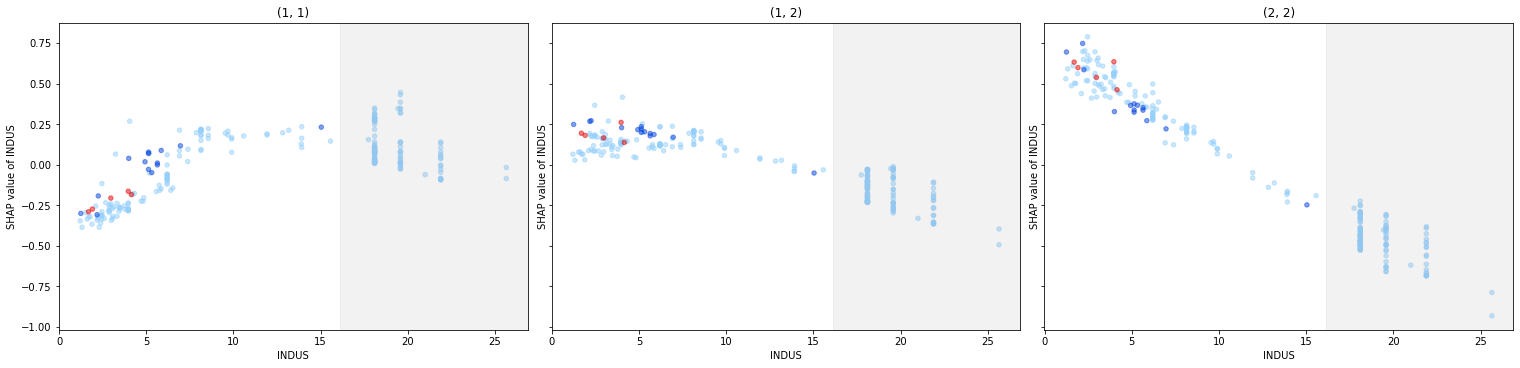

CRIM <= 0.539742303467232
CRIM >= 43.0 --> {'(2, 2)': 3, '(1, 0)': 1, '(0, 0)': 1}


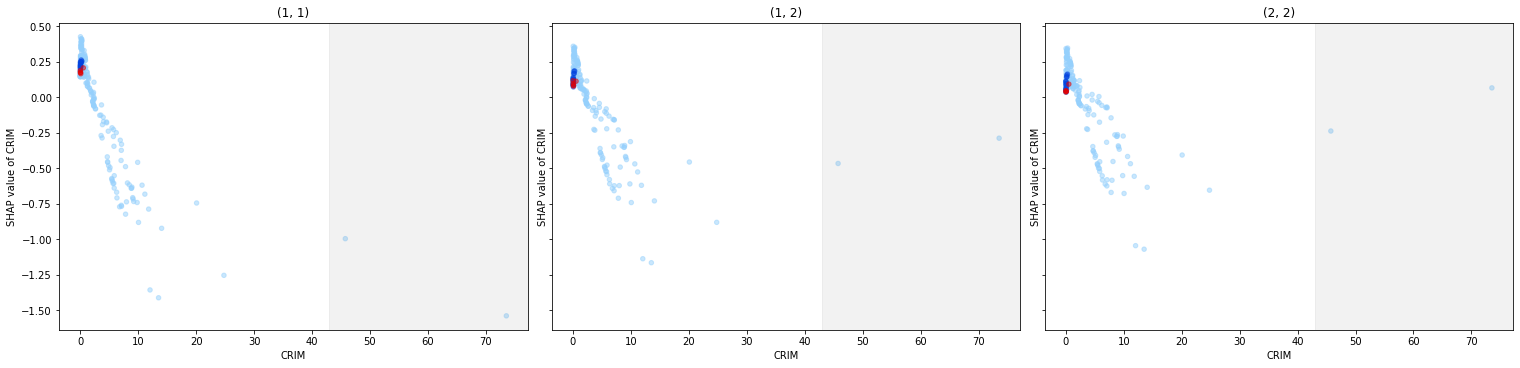

AGE <= 1.0
AGE >= 2.0 --> {'(2, 2)': 5}


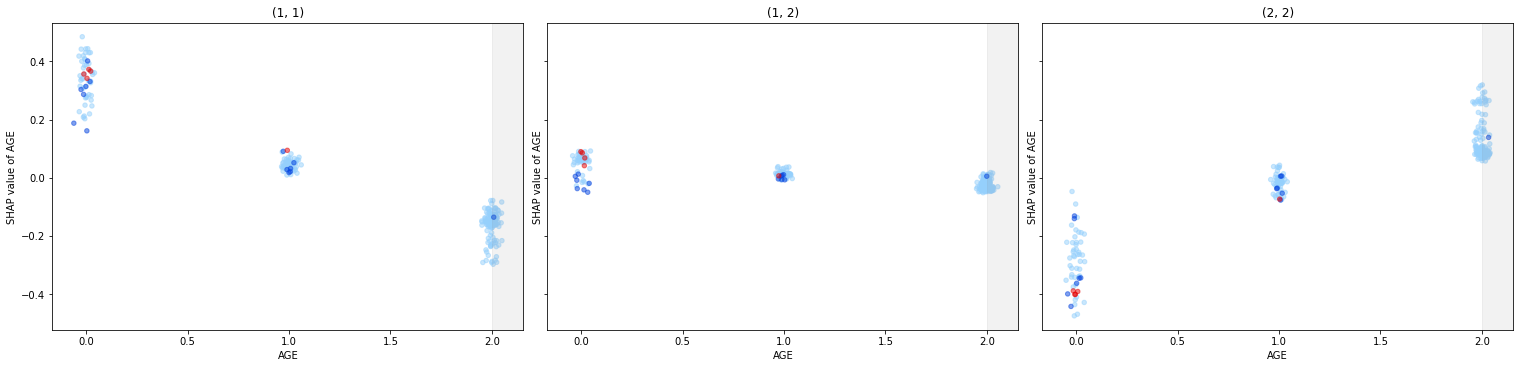

RAD <= 5.0
RAD >= 13.36 --> {'(2, 2)': 5}


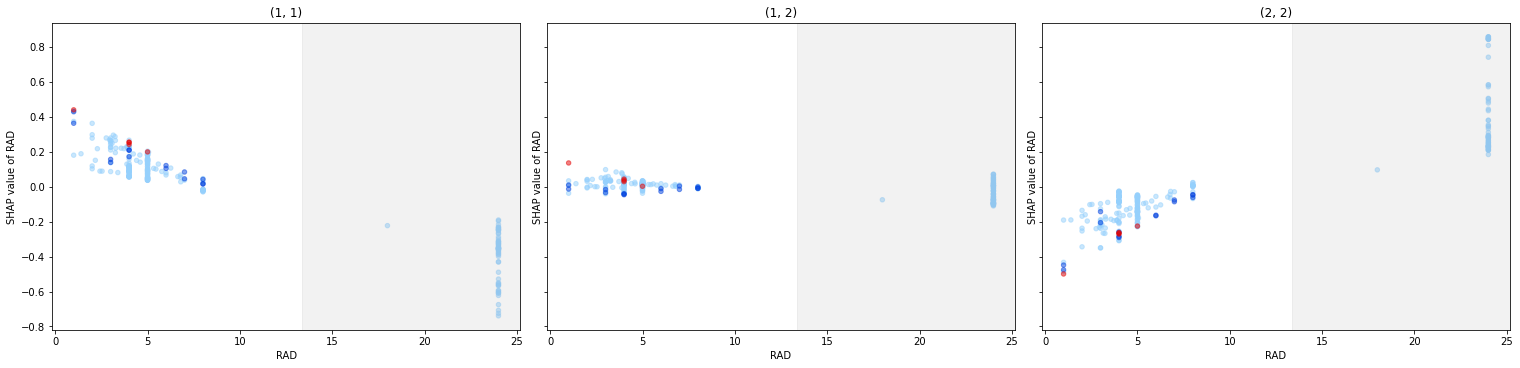

5.936 <= RM <= 7.225002872141104
RM >= 8.64 --> {'(2, 2)': 5}


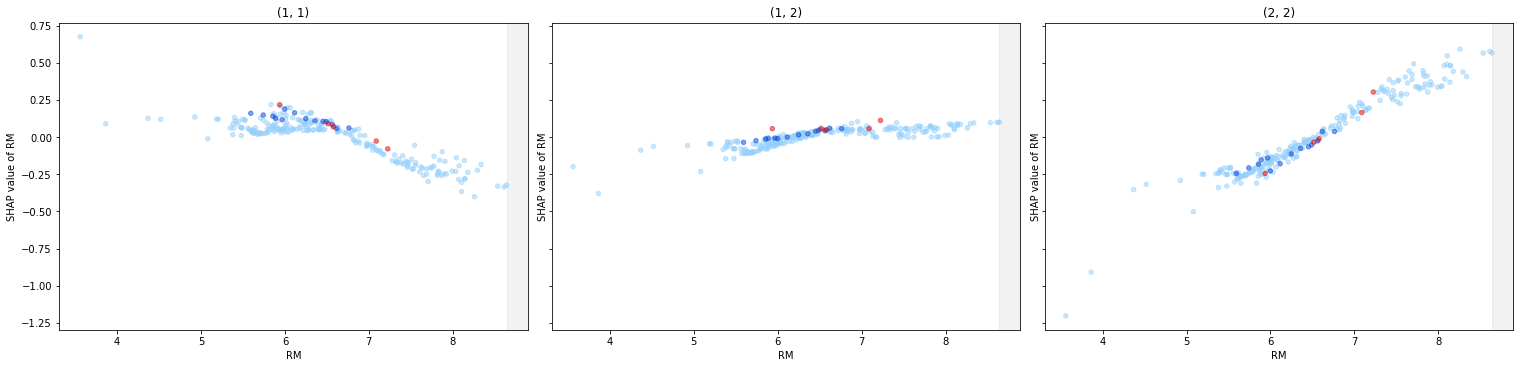

In [64]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

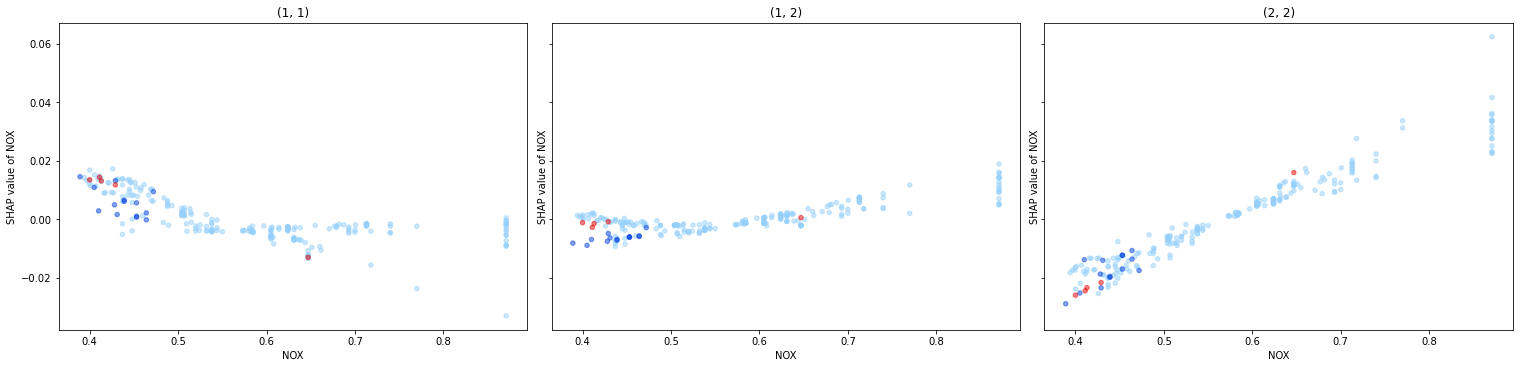

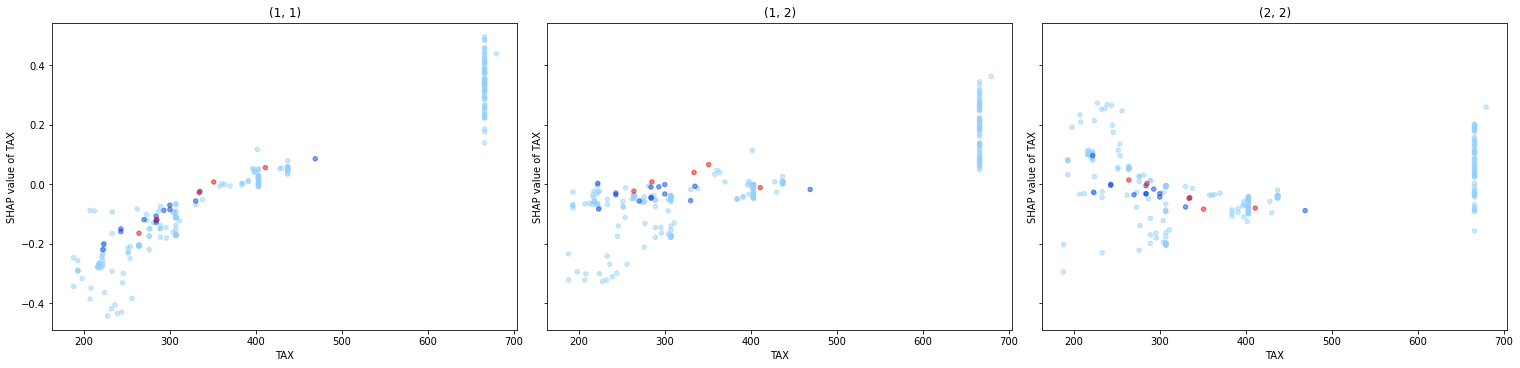

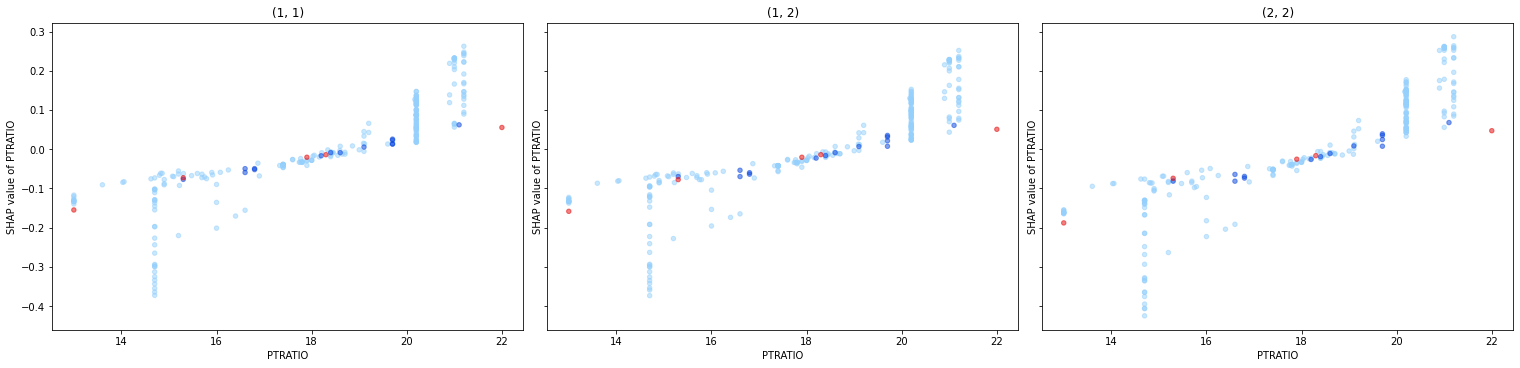

In [65]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

20.0 <= ZN <= 90.0
ZN <= 16.0 --> {'(1, 1)': 5}


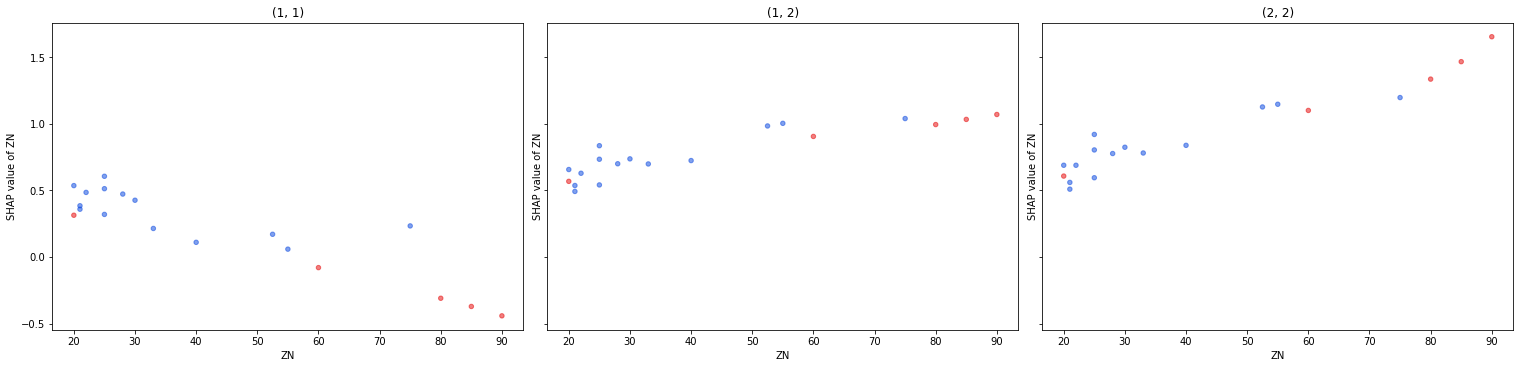

5.49 <= LSTAT <= 9.522242201272585
LSTAT <= 3.58 --> {'(2, 2)': 5}
LSTAT >= 11.59 --> {'(1, 1)': 5}


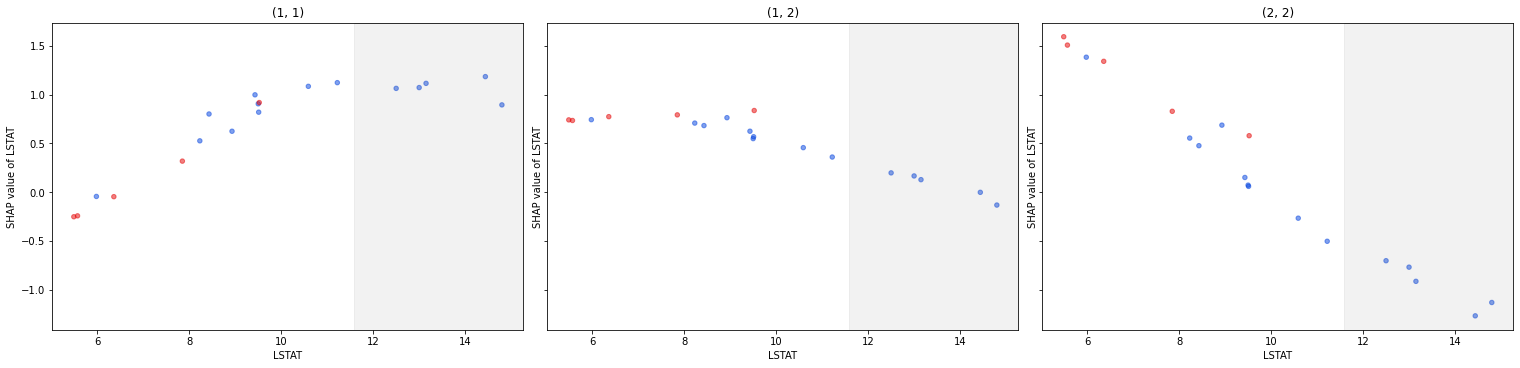

In [66]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.plot_feature(feature, focus=node, alpha=0.5)

### Node RRLL

In [67]:
node = node.get_left()
node.class_counts, node.distance

((1, 2)    4
 (1, 1)    1
 dtype: int64,
 2.048332321891543)

In [68]:
node.get_left().class_counts

(1, 2)    1
dtype: int64

Now the distance is much lower.

60.0 <= ZN <= 90.0
ZN <= 53.0 --> {'(1, 1)': 4}


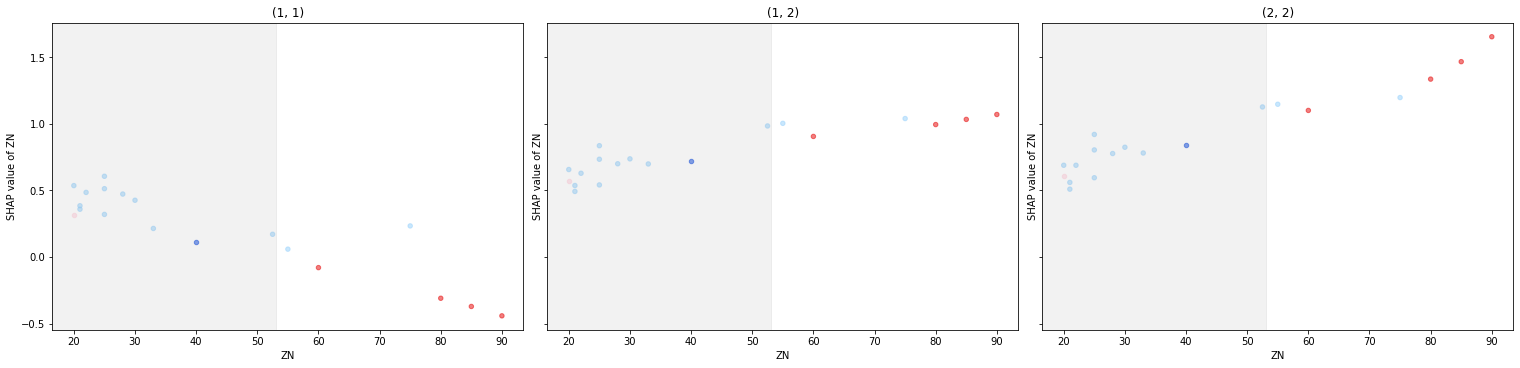

5.49 <= LSTAT <= 7.85
LSTAT <= 3.58 --> {'(2, 2)': 4}
LSTAT >= 11.59 --> {'(1, 1)': 4}


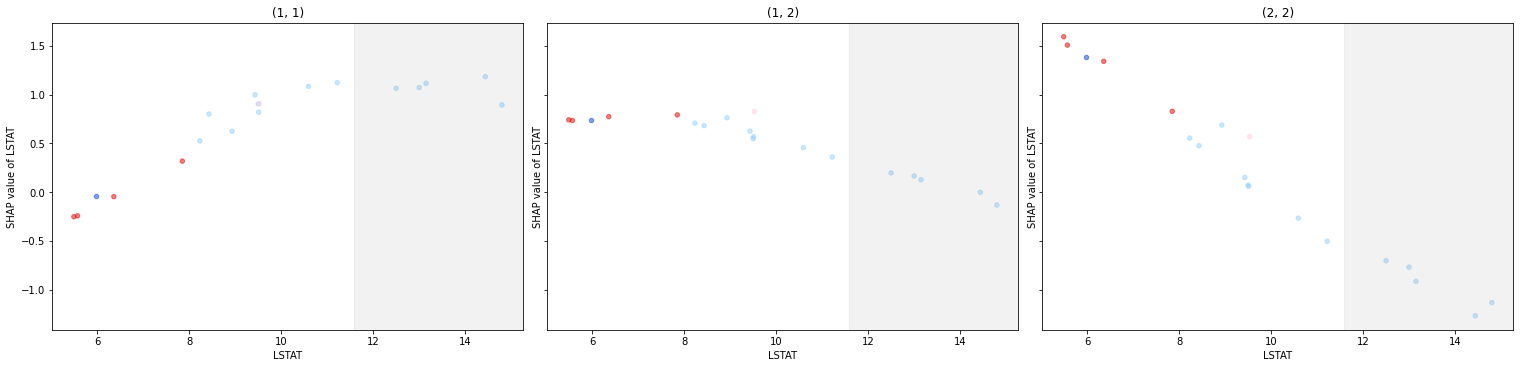

In [70]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

Still, ZN is the most important local feature and the counterfactual now much closer to the instances classified differently. Its feature values are on the upper spectrum of the global range.

In [77]:
node.describe_feature('ZN')

global  local-all  local-diff
count  246.000000   5.000000    4.000000
mean    12.841063  71.000000   78.750000
std     25.552540  20.736441   13.149778
min      0.000000  40.000000   60.000000
25%      0.000000  60.000000   75.000000
50%      0.000000  80.000000   82.500000
75%     20.000000  85.000000   86.250000
max    100.000000  90.000000   90.000000

### Node RRLR

In [78]:
node = node.parent.get_right()
node.class_counts, node.distance

((1, 1)    12
 (1, 2)     1
 (2, 2)     1
 dtype: int64,
 5.722701486725253)

20.0 <= ZN <= 20.0
ZN <= 16.0 --> {'(1, 1)': 1}
ZN >= 26.0 --> {'(2, 2)': 1}


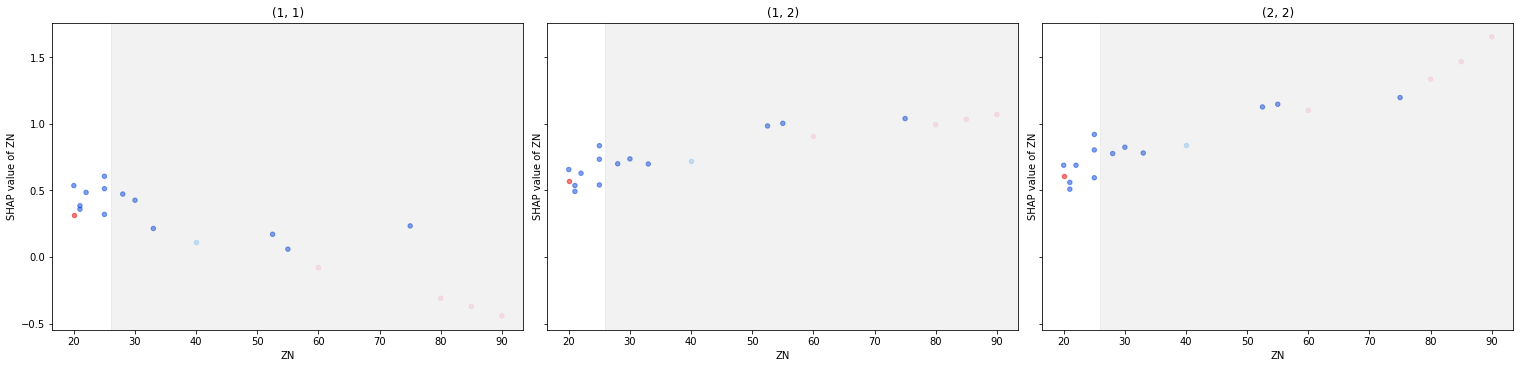

9.522242201272585 <= LSTAT <= 9.522242201272585
LSTAT <= 9.44 --> {'(2, 2)': 1}
LSTAT >= 9.79 --> {'(1, 1)': 1}


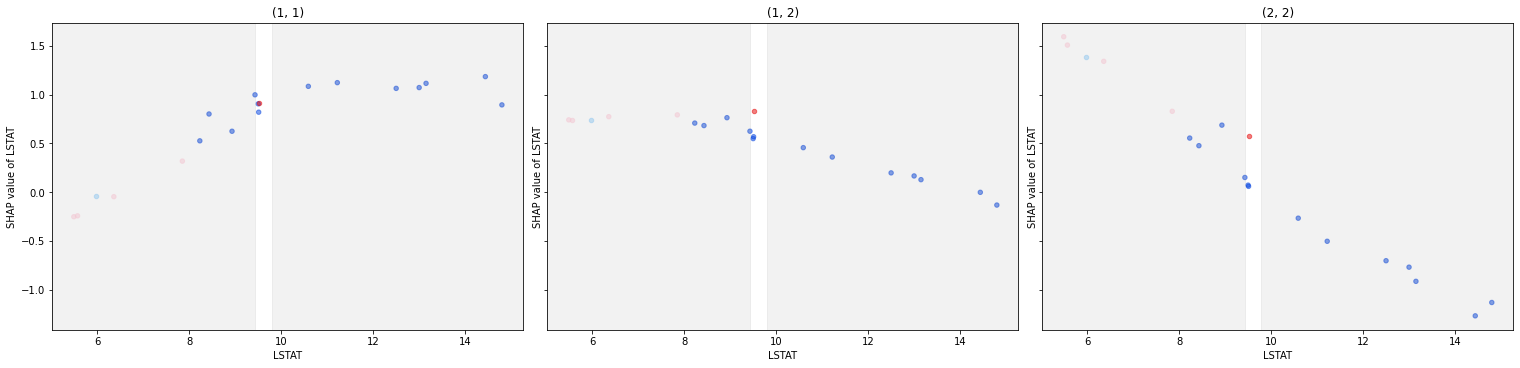

In [73]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

For this instance, ZN is much lower than for the sibling cluster. Further, it also has an upper counterfactual.

## Clustering of Class $(2,1)$ SHAP Values

In [84]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds,
                          '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                          categorical_features=categorical_features,
                          feature_precisions=feature_precisions)

### Node LRL

In [85]:
node.class_counts, node.distance

((2, 2)    96
 (0, 0)    86
 (1, 1)    52
 (1, 2)     5
 (0, 1)     3
 (2, 1)     2
 (1, 0)     2
 dtype: int64,
 67.49967166699163)

In [86]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    96
 (1, 1)    15
 (1, 2)     5
 (2, 1)     2
 dtype: int64,
 17.85348505744029)

In [88]:
node = node.get_right()
node.class_counts, node.distance

((1, 1)    15
 (2, 2)    12
 (1, 2)     5
 (2, 1)     2
 dtype: int64,
 15.378594069782254)

In [90]:
node = node.get_left()
node.class_counts, node.distance

((2, 2)    11
 (2, 1)     2
 (1, 1)     2
 dtype: int64,
 6.667651204980361)

In [91]:
node.get_left().class_counts

(1, 1)    2
(2, 1)    1
dtype: int64

The distance of the main cluster containing the differences is low, the global explanation might be sufficient.

6.48 <= LSTAT <= 7.12
LSTAT <= 6.05 --> {'(2, 2)': 2}
LSTAT >= 7.42 --> {'(1, 1)': 2}


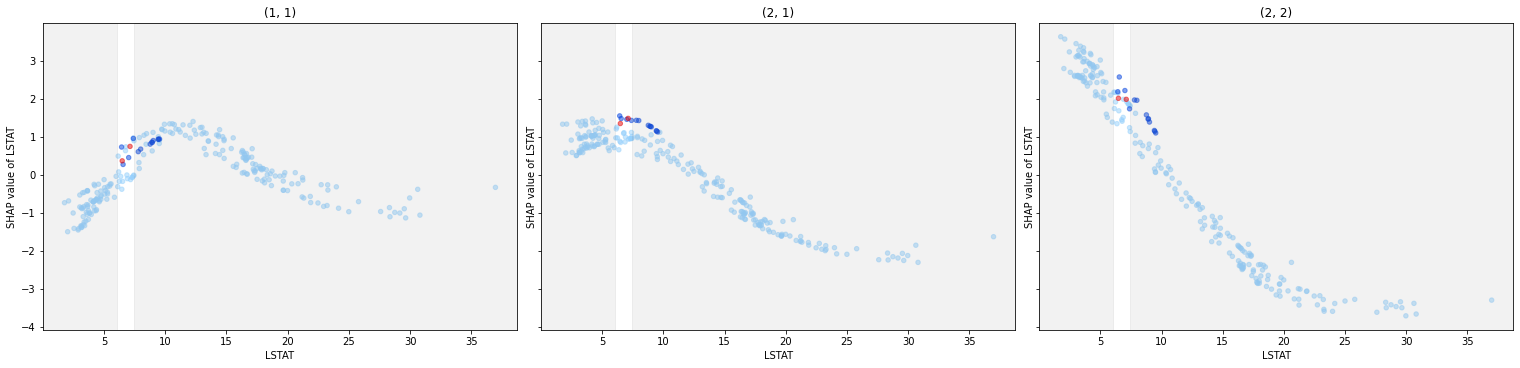

0.10959 <= CRIM <= 4.55587
CRIM >= 9.0 --> {'(2, 0)': 1, '(2, 2)': 1}


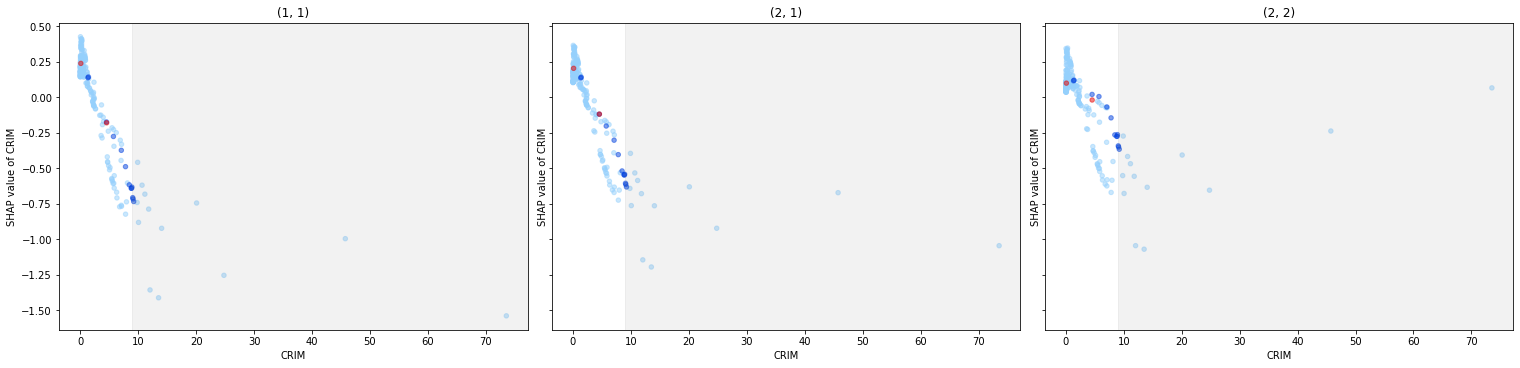

11.93 <= INDUS <= 18.1
INDUS <= 9.8 --> {'(2, 2)': 2}
INDUS >= 19.62 --> {'(1, 1)': 2}


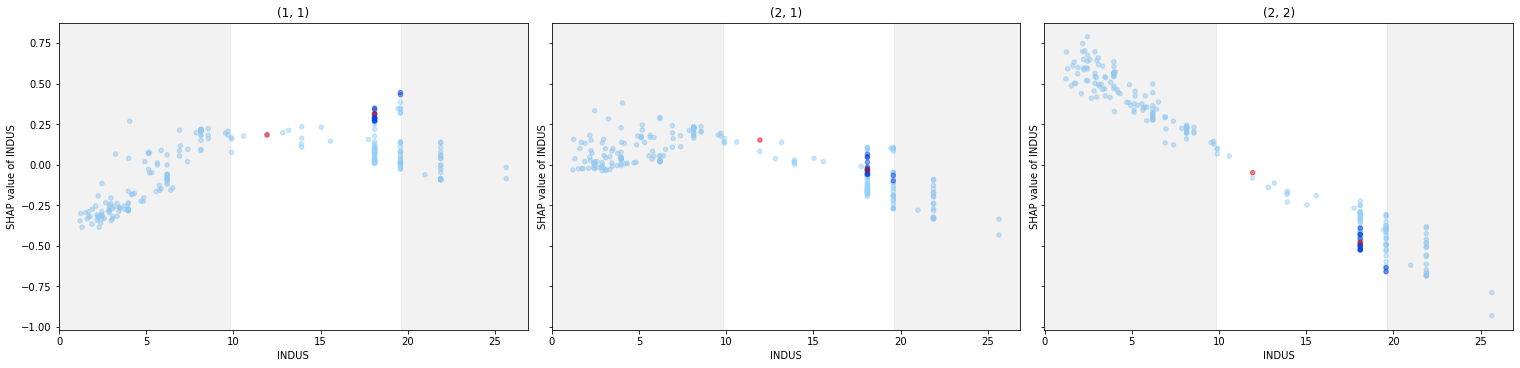

ZN <= 0.0
ZN >= 19.0 --> {'(2, 2)': 2}


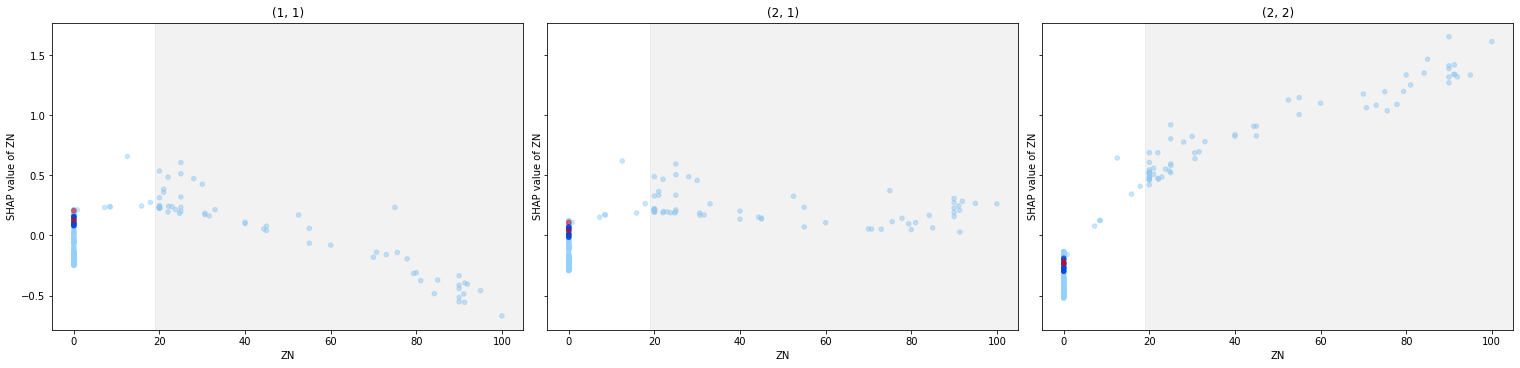

1.6132 <= DIS <= 2.3889
DIS >= 4.18 --> {'(1, 1)': 2}


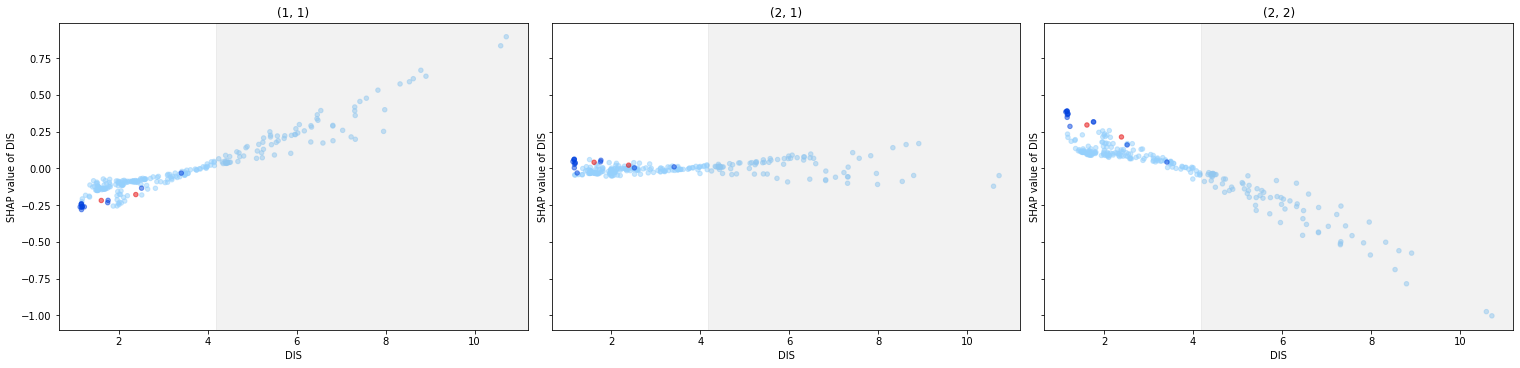

RM <= 6.794
RM >= 7.18 --> {'(2, 2)': 2}


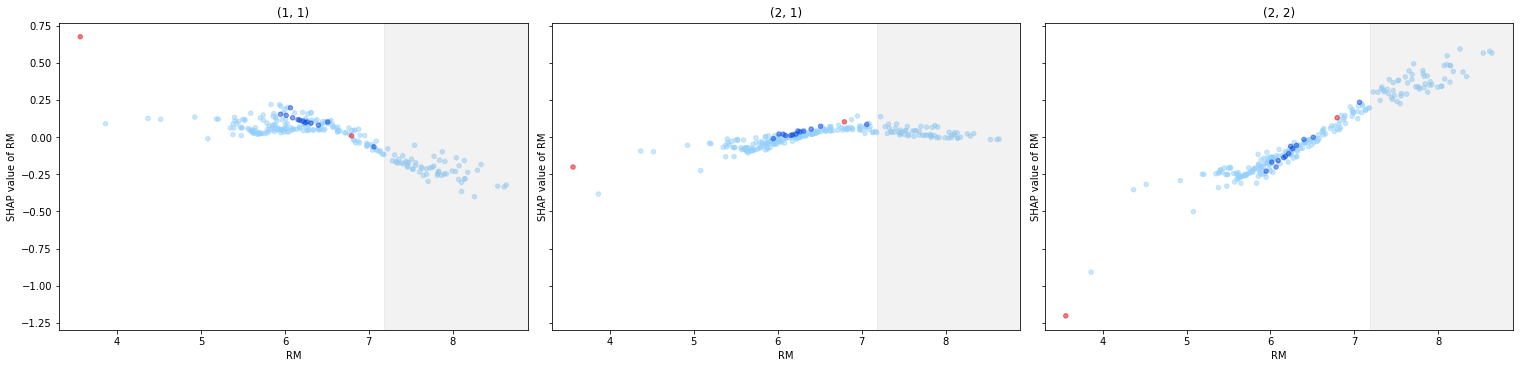

2.0 <= AGE
AGE <= 1.0 --> {'(1, 1)': 2}


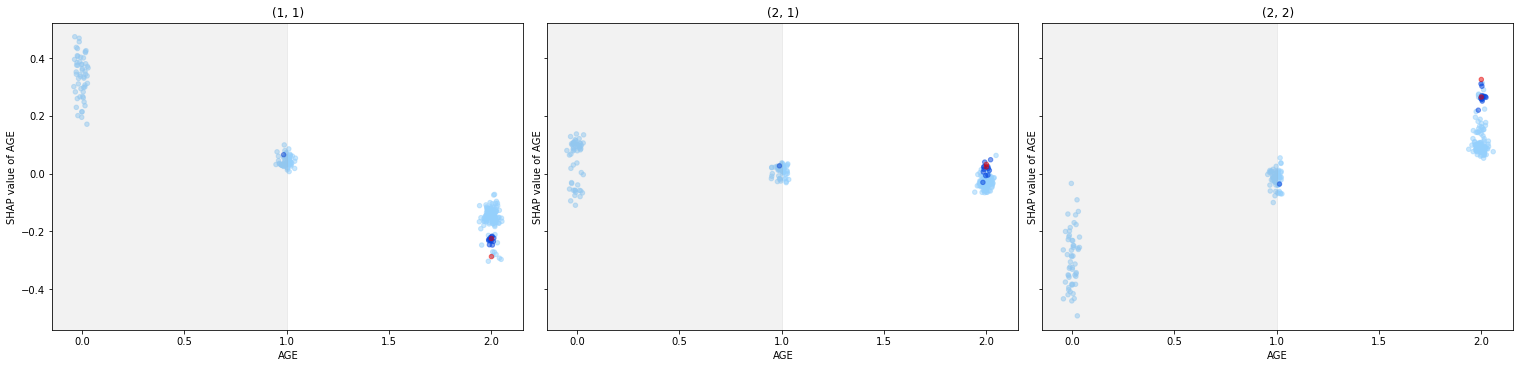

In [92]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature(feature, focus=node, alpha=0.5)

But these two instance differ quite heavily in terms of CRIM and INDUS, both in the top 3 most important features locally. Therefore I will create separate explanations.

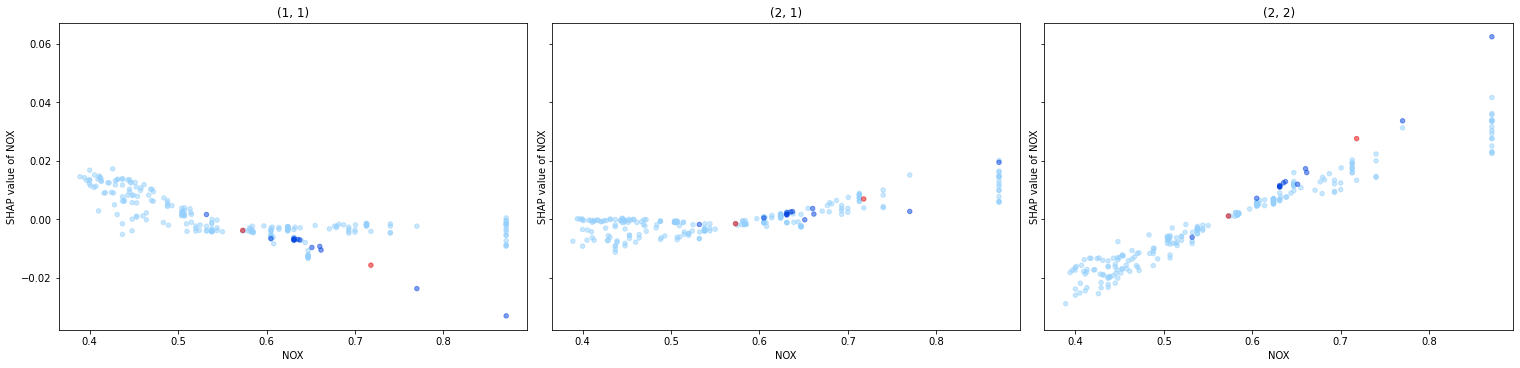

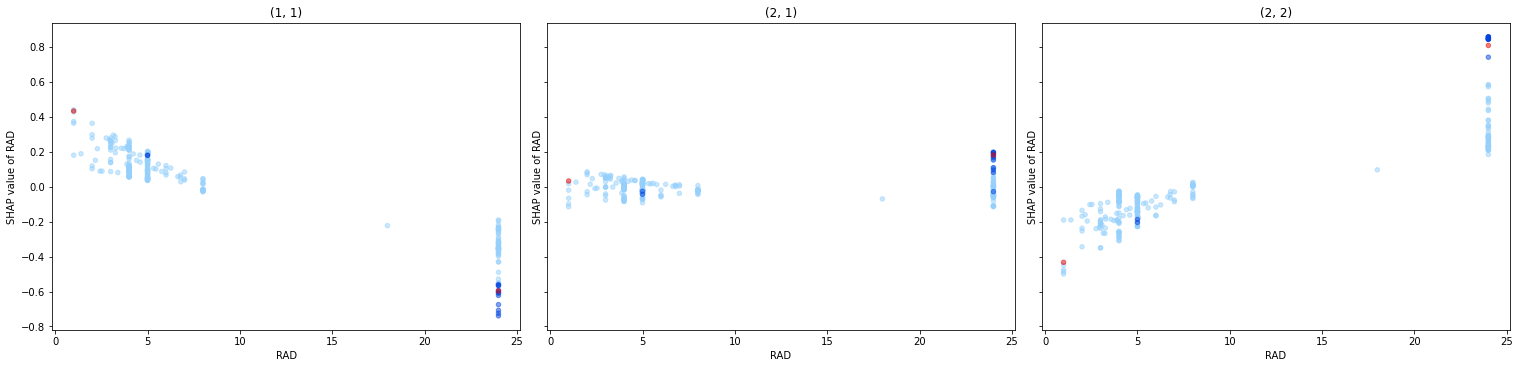

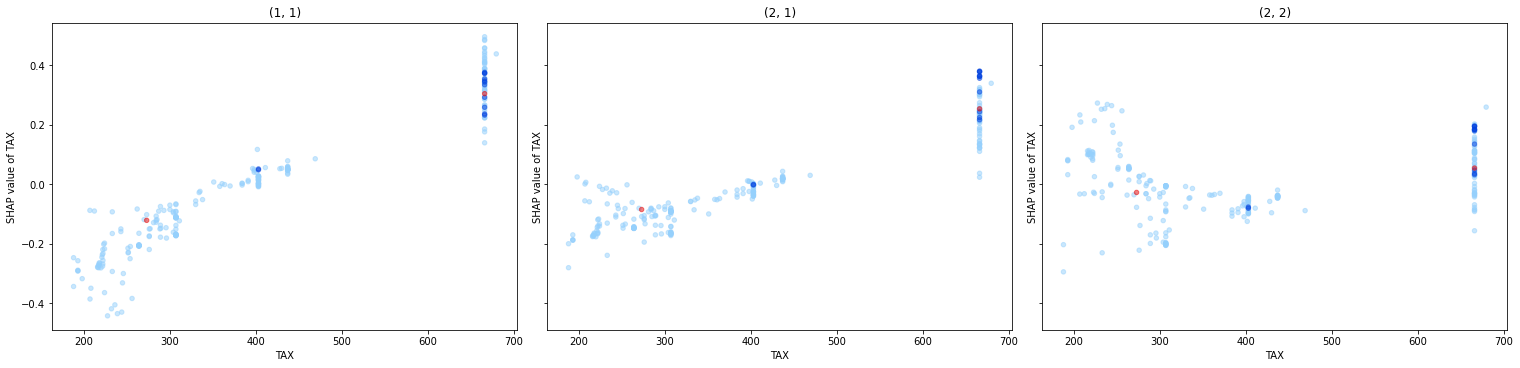

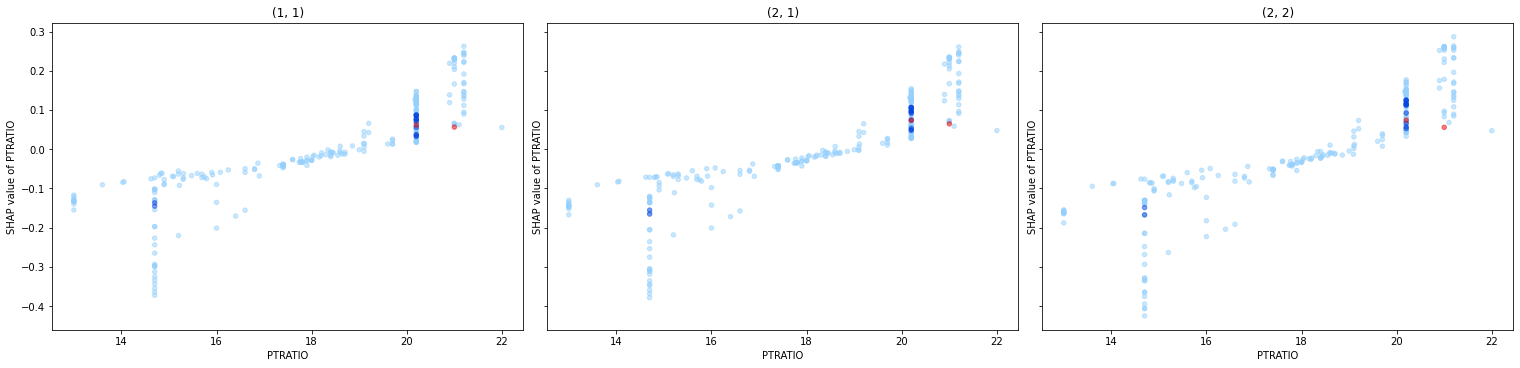

In [93]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature(feature, focus=node, alpha=0.5)

### Node LRLL

In [94]:
node = node.get_left()
node.class_counts, node.distance

((1, 1)    2
 (2, 1)    1
 dtype: int64,
 1.297835765902026)

6.48 <= LSTAT <= 6.48
LSTAT <= 6.05 --> {'(2, 2)': 1}
LSTAT >= 7.32 --> {'(1, 1)': 1}


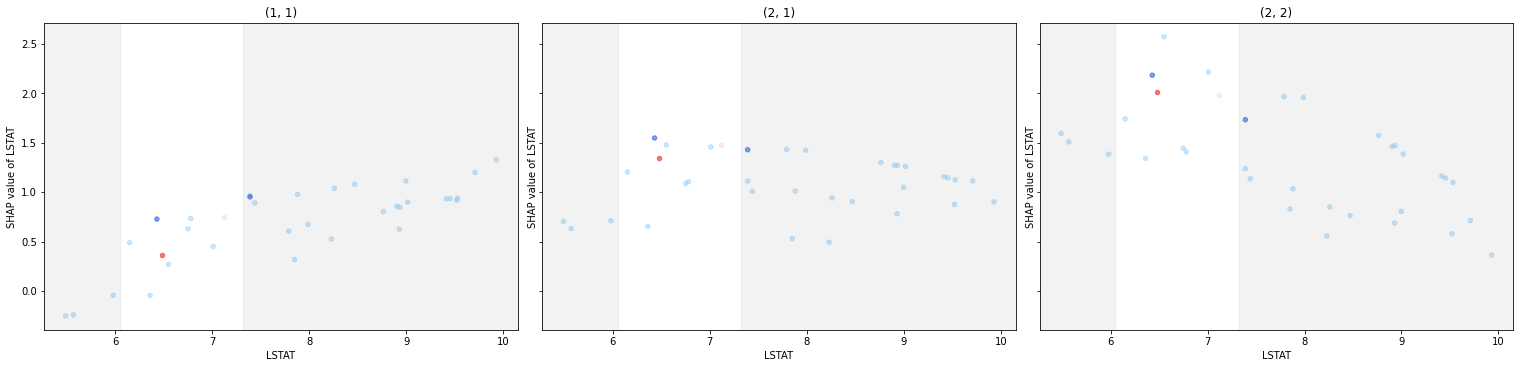

11.93 <= INDUS <= 11.93
INDUS <= 9.8 --> {'(2, 2)': 1}
INDUS >= 16.32 --> {'(1, 1)': 1}


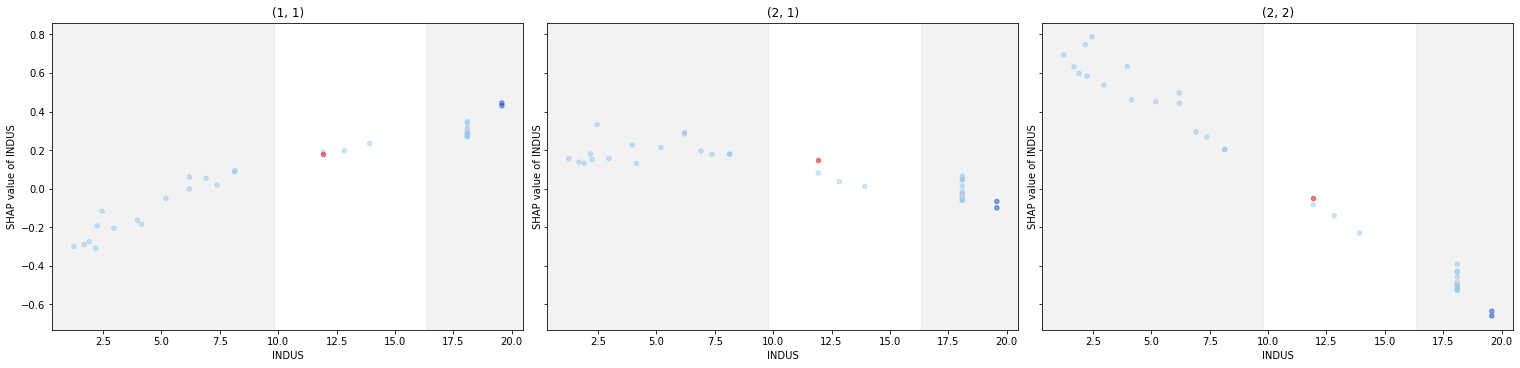

In [96]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)

### Node LRLR

In [97]:
node = node.parent.get_right()
node.class_counts, node.distance

((2, 2)    11
 (2, 1)     1
 dtype: int64,
 3.306338368377892)

7.12 <= LSTAT <= 7.12
LSTAT <= 6.06 --> {'(2, 2)': 1}
LSTAT >= 7.42 --> {'(1, 1)': 1}


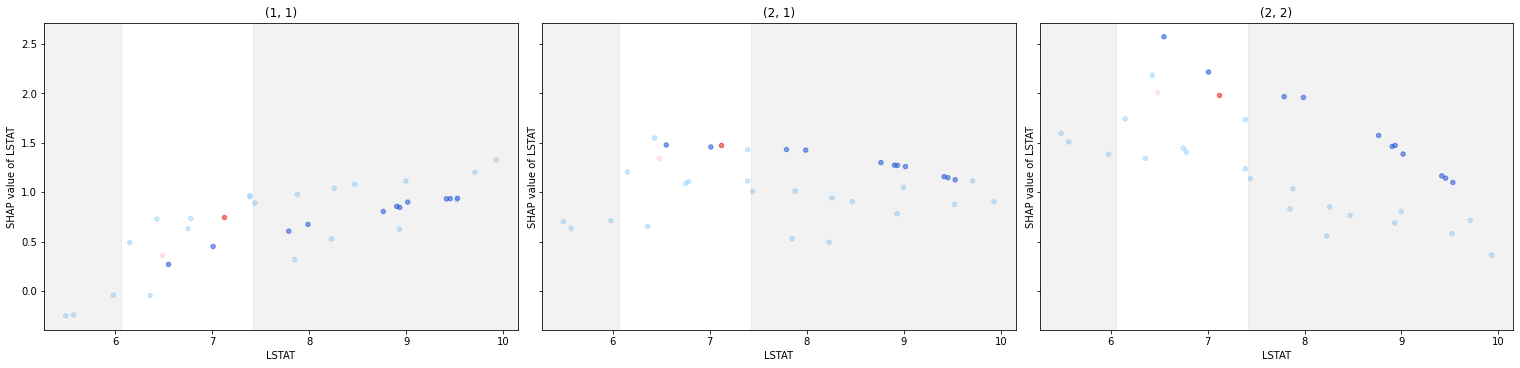

24.0 <= RAD
RAD <= 22.57 --> {'(1, 1)': 1}


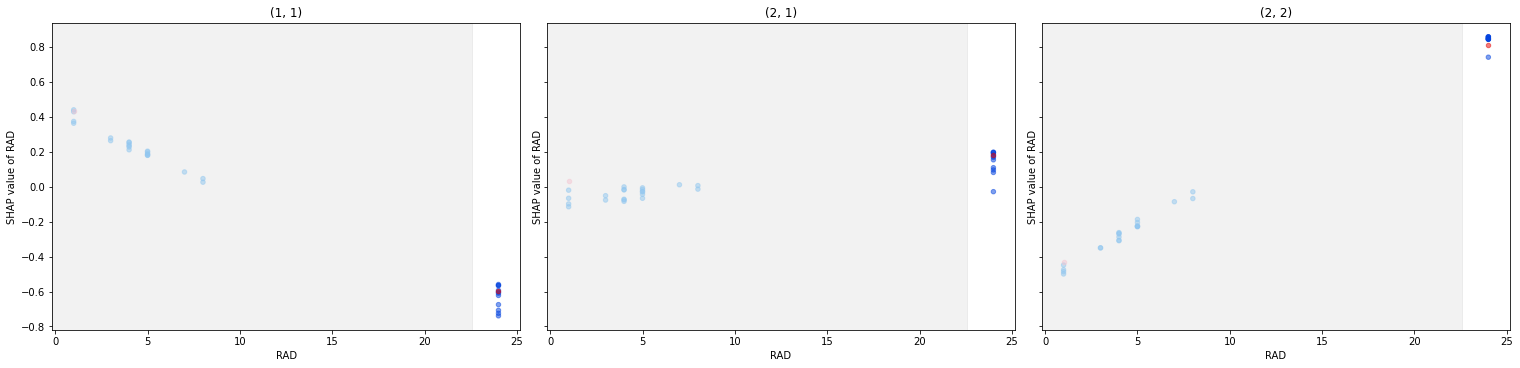

In [98]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.parent.plot_feature(feature, focus=node, alpha=0.5)